In [1]:
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
import lightgbm as lgb
import seaborn as sns

In [2]:
xlsx_file = pd.ExcelFile('./2021-2022_O3&气象五参.xlsx')
sheet_names = xlsx_file.sheet_names
data = pd.DataFrame()

# datat= pd.read_excel('./预测数据.xlsx')
# datat

#得到2021和2022年的数据
df1 = xlsx_file.parse(sheet_names[0])
df2 = xlsx_file.parse(sheet_names[1])
data = pd.concat([df1,df2])
data = data.reset_index(drop=True)
# datat.info()
columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
for column in columns_to_interpolate:
        if column in data.columns:
            data[column] = data[column].interpolate(method='linear')

def daypart(hour):
    if hour in [2,3,4,5]:
        return "dawn"
    elif hour in [6,7,8,9]:
        return "morning"
    elif hour in [10,11,12,13]:
        return "noon"
    elif hour in [14,15,16,17]:
        return "afternoon"
    elif hour in [18,19,20,21]:
        return "evening"
    else: return "midnight"
data['C1705_DATETIME'] = pd.to_datetime(data['C1705_DATETIME'])
data['year'] = data.C1705_DATETIME.dt.year
data['month'] = data.C1705_DATETIME.dt.month
data['day'] = data.C1705_DATETIME.dt.day
data['hour'] = data.C1705_DATETIME.dt.hour
# data['weekday'] = data.C1705_DATETIME.dt.weekday
# data['day_of_Week'] = data.C1705_DATETIME.dt.dayofweek
to_one_hot = data['C1705_DATETIME'].dt.day_name()
# second: one hot encode to 7 columns
days = pd.get_dummies(to_one_hot)
#display data
for column in days.columns:
    data[column] = days[column]
    
raw_dayparts = data['hour'].apply(daypart)
# one hot encoding
dayparts = pd.get_dummies(raw_dayparts)
for column in dayparts.columns:
    data[column] = dayparts[column]


mask = data['O3VAL'] < 0  # 创建一个布尔掩码，表示负值
data.loc[mask, 'O3VAL'] *= -1  # 将负值取反
data_cho = data[data['C0007_PNAME']=='八大关街道']
data2 = data[data['C0007_PNAME']=='北宅街道']
data3 = data[data['C0007_PNAME']=='登州路街道']
data4 = data[data['C0007_PNAME']=='上马街道']
data5 = data[data['C0007_PNAME']=='兴城路街道']

data_cho = data4

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# data_cho['O3VAL'] = scaler.fit_transform(np.array(data_cho['O3VAL'].values.reshape(-1, 1)))
data_cho['QIWENVAL'] = scaler.fit_transform(np.array(data_cho['QIWENVAL'].values.reshape(-1, 1)))
data_cho['FSVAL'] = scaler.fit_transform(np.array(data_cho['FSVAL'].values.reshape(-1, 1)))
data_cho['FXVAL'] = scaler.fit_transform(np.array(data_cho['FXVAL'].values.reshape(-1, 1)))
data_cho['SHIDUVAL'] = scaler.fit_transform(np.array(data_cho['SHIDUVAL'].values.reshape(-1, 1)))
data_cho['YALIVAL'] = scaler.fit_transform(np.array(data_cho['YALIVAL'].values.reshape(-1, 1)))
#data_cho['O3VAL'] = np.sqrt(data1['O3VAL'])
# 创建一个示例时间序列数据
# dates = pd.date_range(start='2021-01-01 00:00:00',end='2022-12-17 23:00:00',freq='H')
# print(data1[data1['C1705_DATETIME'] == '2021-12-31 23:00:00'])
# ts = pd.Series(scaler.fit_transform(data1.loc[0:82703]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates)
'''
dates = pd.date_range(start='2021-01-01 00:00:00',end='2021-12-31 23:00:00',freq='H')
ts = pd.Series(data_cho.loc[0:30480]['O3VAL'].values.reshape(-1, 1).flatten(), index=dates)
# 进行STL分解
stl = STL(ts)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度
result = stl.fit()

dates1 = pd.date_range(start='2022-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H')
ts1 = pd.Series(scaler.fit_transform(data_cho.loc[30480:]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates1)
# 进行STL分解
stl1 = STL(ts1)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度
result1 = stl1.fit()

# 获取分解后的趋势、季节性和残差
trend = result.trend.values
seasonal = result.seasonal.values
residual = result.resid.values

trend1 = result1.trend.values
seasonal1 = result1.seasonal.values
residual1 = result1.resid.values

mean_trend = (trend + trend1) / 2
mean_seasonal = (seasonal + seasonal1) / 2
mean_residual = (residual + residual1) / 2
time_dates = pd.date_range(start='2024-04-01 00:00:00',end='2024-6-30 23:00:00',freq='H')

trend_scaled = scaler.fit_transform(np.array(mean_trend.reshape(-1, 1)))[2160:4344]
seasonal_scaled = scaler.fit_transform(np.array(mean_seasonal.reshape(-1, 1)))[2160:4344]
residual_scaled = scaler.fit_transform(np.array(mean_residual.reshape(-1, 1)))[2160:4344]

trend_scaled = np.array(mean_trend.reshape(-1, 1))[2160:4344]
seasonal_scaled = np.array(mean_seasonal.reshape(-1, 1))[2160:4344]
residual_scaled = np.array(mean_residual.reshape(-1, 1))[2160:4344]


trend_array = {}
seasonal_array = {}
residual_array = {}
for i in range(0, 2184):
    trend_array[time_dates[i]] = trend_scaled[i][0]
    seasonal_array[time_dates[i]] = seasonal_scaled[i][0]
    residual_array[time_dates[i]] = residual_scaled[i][0]
'''   

C:\Users\lenovo\AppData\Local\Temp\ipykernel_30092\989453667.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cho['QIWENVAL'] = scaler.fit_transform(np.array(data_cho['QIWENVAL'].values.reshape(-1, 1)))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_30092\989453667.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cho['FSVAL'] = scaler.fit_transform(np.array(data_cho['FSVAL'].values.reshape(-1, 1)))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_30092\989453667.py:71: SettingWithCopyWarning: 
A

"\ndates = pd.date_range(start='2021-01-01 00:00:00',end='2021-12-31 23:00:00',freq='H')\nts = pd.Series(data_cho.loc[0:30480]['O3VAL'].values.reshape(-1, 1).flatten(), index=dates)\n# 进行STL分解\nstl = STL(ts)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度\nresult = stl.fit()\n\ndates1 = pd.date_range(start='2022-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H')\nts1 = pd.Series(scaler.fit_transform(data_cho.loc[30480:]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates1)\n# 进行STL分解\nstl1 = STL(ts1)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度\nresult1 = stl1.fit()\n\n# 获取分解后的趋势、季节性和残差\ntrend = result.trend.values\nseasonal = result.seasonal.values\nresidual = result.resid.values\n\ntrend1 = result1.trend.values\nseasonal1 = result1.seasonal.values\nresidual1 = result1.resid.values\n\nmean_trend = (trend + trend1) / 2\nmean_seasonal = (seasonal + seasonal1) / 2\nmean_residual = (residual + residual1) / 2\ntime_dates = pd.date_range(start='2024-04-01 00:00:00',end='2024-6-30 23:00:00',freq='H')\n\ntr

In [3]:
datat= pd.read_excel('7.30预测.xls')

#datat = datat[datat['C0007_PNAME'] == '八大关街道']
#datat = datat[datat['C0007_PNAME'] == '北宅街道']
#datat = datat[datat['C0007_PNAME'] == '登州路街道']
datat = datat[datat['C0007_PNAME'] == '上马街道']


datat = datat.rename(columns={"TO_CHAR(H.C1705_DATETIME,'YYYY": '日期'})
datat
zhihou = 28*24+1

In [4]:
datat

C0007_SUBSTATION_ID C0007_PNAME             日期  QIWENVAL  FSVAL  \
6515                13768        上马街道  2024-04-01 00     9.303  3.363   
6516                13768        上马街道  2024-04-01 01     9.020  3.339   
6517                13768        上马街道  2024-04-01 02     8.821  2.842   
6518                13768        上马街道  2024-04-01 03     8.758  2.100   
6519                13768        上马街道  2024-04-01 04     8.672  3.291   
...                   ...         ...            ...       ...    ...   
8694                13768        上马街道  2024-06-30 19    27.224  4.225   
8695                13768        上马街道  2024-06-30 20    26.675  2.992   
8696                13768        上马街道  2024-06-30 21    26.108  3.029   
8697                13768        上马街道  2024-06-30 22    25.625  2.797   
8698                13768        上马街道  2024-06-30 23    25.343  2.805   

        FXVAL  SHIDUVAL   YALIVAL  O3VAL  
6515  250.128    69.734  1008.992   81.0  
6516  194.981    74.597  1009.133   87.0  
6517  231.582    79.270  1009.249   81.0  
6518  288.866    82.009  1008.938   72.0  
6519  222.363    84.449  1008.754   69.0  
...       ...       ...       ...    ...  
8694  166.603    67.630   995.506  119.0  
8695  249.216    69.821   996.083  109.0  
8696  252.613    73.116   996.305   92.0  
8697  139.440    77.822   996.917   87.0  
8698      NaN    80.696   997.212   76.0  

[2184 rows x 9 columns]

In [5]:
import os
import pandas as pd
def get_season(month):
    if month in [2, 3, 4]:
        return 1
    elif month in [5, 6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    elif month in [12, 1]:
        return 4
def calculate_wind_speed(U, V):
    return np.sqrt(U**2 + V**2)   

def calculate_wind_direction(U, V):
    # 确保U和V没有缺失值
    U = np.nan_to_num(U)
    V = np.nan_to_num(V)
    direction = np.arctan2(U, V) * (180 / np.pi)  # 转换为角度
    direction = np.mod(direction + 360, 360)  # 确保风向在0到360度之间
    return direction

folder_path = "./wrfout/"
files = os.listdir(folder_path)
columns_to_convert = ['U10', 'V10', '气温开尔文', 'YALIVAL', 'SHIDUVAL']
df_list = []
date_format = "%Y-%m-%d_%H_%M_%S"
for file in files:
    # 获取完整路径
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path, delimiter='\s+', header=None, engine='python',skiprows=1,
                       usecols=[0, 1, 2, 3, 5, 6, 7],
                       names=['日期', '站点', 'U10', 'V10', '气温开尔文', 'YALIVAL', 'SHIDUVAL'])
    
    #data = data[data['站点'] == 'badaguan']
    #data = data[data['站点'] == 'beizhai']
    #data = data[data['站点'] == 'dengzhoulu']
    data = data[data['站点'] == 'shangma']


    data['year'] = data['日期'].str[:4].astype(int)
    data['month'] = data['日期'].str[5:7].astype(int)
    data['day'] = data['日期'].str[8:10].astype(int)
    data['hour'] = data['日期'].str[11:13].astype(int)
    for column in columns_to_convert:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        data['FSVAL'] = calculate_wind_speed(data['U10'], data['V10'])
        data['FXVAL'] = calculate_wind_direction(data['U10'], data['V10'])
    data['QIWENVAL'] = data['气温开尔文'] - 273.15
    columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
    for column in columns_to_interpolate:
        if column in data.columns:
            data[column] = data[column].interpolate(method='linear')
    data['日期'] = pd.to_datetime(data['日期'], format=date_format)
    df_list.append(data)

def is_weekday_series(series):
    def is_weekday(date):
        weekday = date.weekday()
        return weekday < 5

    return series.apply(is_weekday)

df_list 

[                     日期       站点   U10   V10   气温开尔文  YALIVAL  SHIDUVAL  year  \
 3   2024-05-09 00:00:00  shangma -1.40  4.89  286.38  1019.95     67.26  2024   
 8   2024-05-09 01:00:00  shangma -1.51  4.72  286.15  1020.21     68.08  2024   
 13  2024-05-09 02:00:00  shangma -1.01  4.66  286.04  1020.18     66.30  2024   
 18  2024-05-09 03:00:00  shangma -0.32  3.93  285.57  1020.20     58.30  2024   
 23  2024-05-09 04:00:00  shangma -0.14  3.73  285.16  1020.47     54.79  2024   
 ..                  ...      ...   ...   ...     ...      ...       ...   ...   
 938 2024-05-16 19:00:00  shangma -4.28  6.33  287.44  1018.60     88.64  2024   
 943 2024-05-16 20:00:00  shangma -3.04  6.59  287.31  1018.84     85.21  2024   
 948 2024-05-16 21:00:00  shangma -2.02  6.49  286.99  1019.13     87.41  2024   
 953 2024-05-16 22:00:00  shangma -2.26  6.82  286.56  1019.24     92.78  2024   
 958 2024-05-16 23:00:00  shangma -2.27  6.26  286.33  1019.27     96.36  2024   
 
      month  d

In [6]:
datat['日期'] = pd.to_datetime(datat['日期'])
datat['year'] = datat.日期.dt.year
datat['month'] = datat.日期.dt.month
datat['day'] = datat.日期.dt.day
datat['hour'] = datat.日期.dt.hour
datat['is_weekday'] = is_weekday_series(datat.日期)
datat['weekday'] = datat.日期.dt.weekday
#datat['O3VAL'] = np.sqrt(datat['O3VAL'])

# datat1['O3_roll_mean_24'] = datat1['O3VAL'].rolling(window=24).mean()
# datat1['O3_roll_max_24'] = datat1['O3VAL'].rolling(window=24).max()
# datat1['O3_roll_min_24'] = datat1['O3VAL'].rolling(window=24).min()


columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
for column in columns_to_interpolate:
    if column in datat.columns:
        datat[column] = datat[column].interpolate(method='linear')


to_one_hot1 = datat['日期'].dt.day_name()
days1 = pd.get_dummies(to_one_hot1)
for column in days1.columns:
    datat[column] = days[column]
    
raw_dayparts = datat['hour'].apply(daypart)
dayparts = pd.get_dummies(raw_dayparts)
for column in dayparts.columns:
    datat[column] = dayparts[column]
datat['Trend'] = 0
datat['Seasonal'] = 0
datat['residual'] = 0

# datat['O3_roll_mean_24'] = datat['O3VAL'].rolling(window=24).mean()
# datat['O3_roll_max_24'] = datat['O3VAL'].rolling(window=24).max()
# datat['O3_roll_min_24'] = datat['O3VAL'].rolling(window=24).min()
num = 0
#for index, row in datat.iterrows():
    
    # if row['日期'].strftime('%Y-%m-%d %H:%M:%S') == '2024-05-09 00:00:00':
    #     num = 1
    # # if row['日期'].strftime('%Y-%m-%d %H:%M:%S') == '2024-05-17 00:00:00':
    # #     num = 0   
    # if num != 0:
    #     if num > 24:
    #         row['O3_roll_mean_24'] = 0
    #         row['O3_roll_max_24'] = 0
    #         row['O3_roll_min_24'] = 0
    #     else:
    #         row['O3_roll_mean_24'] = datat.loc[index-num, 'O3_roll_mean_24']
    #         row['O3_roll_max_24'] = datat.loc[index-num, 'O3_roll_max_24']
    #         row['O3_roll_min_24'] = datat.loc[index-num, 'O3_roll_min_24']
    #     num += 1
    #if row['日期'] in trend_array:
    #    datat.loc[index, 'Trend'] = trend_array[row['日期']]
    #    datat.loc[index, 'Seasonal'] = seasonal_array[row['日期']]
    #    datat.loc[index, 'residual'] = seasonal_array[row['日期']]

In [7]:
def add_columns(df):
    for i in range(1, 28*24+1):  # Loop through 1 to 24
        new_col_name = f"O3VAL_{i}"  # New column name based on index
        df[new_col_name] = df['O3VAL'].shift(i)
    # 结束之后
    # df.dropna(axis=0,
    #       how='any',
    #       subset=None,
    #       inplace=True)
    # for i in range(2, 7*24+1):
    #     old_col_name = f"O3VAL_{i-1}"
    #     cur_col_name = f"O3VAL_{i}"
    #     df[cur_col_name] = df[old_col_name] + df[cur_col_name]

    # sum = 0
    # label_sum = 1
    # for i in range(7*24 + 1, 28*24 + 1):
    #     # 构建列名
    #     col_name = f"WEEK_O3VAL_{label_sum}"
    #     del_col_name = f"O3VAL_{i}"
    #     fur_col_name = f"O3VAL_{i + 1}"
    #     if i == 7 * 24 + 7*24+1 or i == 7 * 24 + 14*24+1 or i == 7 * 24 + 21*24:
    #         del_col_name = f"WEEK_O3VAL_{label_sum -1}"
    #     # 累加本周的值
    #     if fur_col_name in df.columns:
    #         df[fur_col_name] = df[del_col_name] + df[fur_col_name]
    #     else:
    #         df[col_name] = df[del_col_name]
    #     del_col_name = f"O3VAL_{i}"
    #     # 计算累加和
    #     sum += 1
        
    #     # 如果累加到一周 (7 * 24 个时间步)
    #     if sum == 7 * 24:
    #         # 构建新特征列
    #         df[col_name] = df[del_col_name]
    #         # 重置累加器
    #         sum = 0
    #         label_sum += 1
    #     df.drop(del_col_name, axis=1, inplace=True)



# Call the function to add columns
add_columns(datat)
datat.dropna(axis=0,
          how='any',
          subset=None,
          inplace=True)

o3_columns = ['O3VAL_' + str(i) for i in range(1,28*24+1)]
datat['max_O3'] = datat[o3_columns].max(axis=1)
datat['min_O3'] = datat[o3_columns].min(axis=1)
datat['avg_O3'] = datat[o3_columns].mean(axis=1)
datat['median_O3'] = datat[o3_columns].median(axis=1)
datat['stddev_O3'] = datat[o3_columns].std(axis=1)

random_values = np.random.uniform(-10, 10, size=len(datat['O3VAL_1']))
new_values = datat['O3VAL_1'] + random_values
# 确保所有值都大于1
new_values = np.maximum(new_values, 1)
# 更新DataFrame中的值
datat['O3VAL_1'] = new_values


datat

C:\Users\lenovo\AppData\Local\Temp\ipykernel_30092\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_30092\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_30092\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

C0007_SUBSTATION_ID C0007_PNAME                  日期  QIWENVAL  FSVAL  \
7187                13768        上马街道 2024-04-29 00:00:00    15.876  1.423   
7188                13768        上马街道 2024-04-29 01:00:00    15.537  1.106   
7189                13768        上马街道 2024-04-29 02:00:00    14.596  1.647   
7190                13768        上马街道 2024-04-29 03:00:00    13.920  1.963   
7191                13768        上马街道 2024-04-29 04:00:00    12.624  3.184   
...                   ...         ...                 ...       ...    ...   
8694                13768        上马街道 2024-06-30 19:00:00    27.224  4.225   
8695                13768        上马街道 2024-06-30 20:00:00    26.675  2.992   
8696                13768        上马街道 2024-06-30 21:00:00    26.108  3.029   
8697                13768        上马街道 2024-06-30 22:00:00    25.625  2.797   
8698                13768        上马街道 2024-06-30 23:00:00    25.343  2.805   

        FXVAL  SHIDUVAL   YALIVAL  O3VAL  year  ...  O3VAL_668  O3VAL_669  \
7187  176.737    65.392  1009.193   53.0  2024  ...       69.0       72.0   
7188  210.438    66.605  1008.905   36.0  2024  ...       67.0       69.0   
7189  118.960    75.024  1008.391   38.0  2024  ...       70.0       67.0   
7190  126.362    80.414  1007.808   23.0  2024  ...       62.0       70.0   
7191  112.965    91.447  1008.070   20.0  2024  ...       77.0       62.0   
...       ...       ...       ...    ...   ...  ...        ...        ...   
8694  166.603    67.630   995.506  119.0  2024  ...      103.0      130.0   
8695  249.216    69.821   996.083  109.0  2024  ...       94.0      103.0   
8696  252.613    73.116   996.305   92.0  2024  ...       90.0       94.0   
8697  139.440    77.822   996.917   87.0  2024  ...      108.0       90.0   
8698  139.440    80.696   997.212   76.0  2024  ...      107.0      108.0   

      O3VAL_670  O3VAL_671  O3VAL_672  max_O3  min_O3      avg_O3  median_O3  \
7187       81.0       87.0       81.0   198.0     5.0   91.536458       90.0   
7188       72.0       81.0       87.0   198.0     5.0   91.494792       90.0   
7189       69.0       72.0       81.0   198.0     5.0   91.418899       90.0   
7190       67.0       69.0       72.0   198.0     5.0   91.354911       90.0   
7191       70.0       67.0       69.0   198.0     5.0   91.281994       90.0   
...         ...        ...        ...     ...     ...         ...        ...   
8694      138.0      154.0      161.0   267.0     9.0  102.543899       95.0   
8695      130.0      138.0      154.0   267.0     9.0  102.481399       95.0   
8696      103.0      130.0      138.0   267.0     9.0  102.414435       95.0   
8697       94.0      103.0      130.0   267.0     9.0  102.345982       95.0   
8698       90.0       94.0      103.0   267.0     9.0  102.281994       95.0   

      stddev_O3  
7187  30.810653  
7188  30.843838  
7189  30.917571  
7190  30.983593  
7191  31.086697  
...         ...  
8694  41.615694  
8695  41.559272  
8696  41.512364  
8697  41.491518  
8698  41.481963  

[1512 rows x 708 columns]

In [8]:
# Merge the DataFrames on the date
# pd.set_option('display.max_rows', None)  # 取消行数限制
# pd.set_option('display.max_columns', None)  # 取消列数限制
o3_columns = ['O3VAL_' + str(i) for i in range(1,28*24+1)]
day_time_columns = ['dawn','morning','noon','afternoon','evening','midnight']
sta_o3 = ['max_O3','min_O3','avg_O3','median_O3','stddev_O3']
# windows_o3 = ['O3_roll_mean_24','O3_roll_max_24','O3_roll_min_24']
merged_df_list = [] 
X_list = []
y_list = []
for i in range(len(df_list)):
    merged_df = pd.merge_asof(df_list[i], datat[['日期', 'O3VAL','Trend','Seasonal','residual','is_weekday']+o3_columns+day_time_columns+sta_o3], left_on='日期', right_on='日期', direction='nearest')
    # merged_df['O3VAL'] = scaler.fit_transform(np.array(merged_df['O3VAL'].values.reshape(-1, 1)))
    merged_df['QIWENVAL'] = scaler.fit_transform(np.array(merged_df['QIWENVAL'].values.reshape(-1, 1)))
    merged_df['FSVAL'] = scaler.fit_transform(np.array(merged_df['FSVAL'].values.reshape(-1, 1)))
    merged_df['FXVAL'] = scaler.fit_transform(np.array(merged_df['FXVAL'].values.reshape(-1, 1)))
    merged_df['SHIDUVAL'] = scaler.fit_transform(np.array(merged_df['SHIDUVAL'].values.reshape(-1, 1)))
    merged_df['YALIVAL'] = scaler.fit_transform(np.array(merged_df['YALIVAL'].values.reshape(-1, 1)))
    merged_df_list.append(merged_df)
    X = merged_df[['year', 'month', 'day', 'hour', 'is_weekday'] +o3_columns+day_time_columns+['QIWENVAL'	,'FSVAL'	,'SHIDUVAL'	,'YALIVAL']+ sta_o3 ]
    y = merged_df['O3VAL']
    X_list.append(X)
    y_list.append(y)


In [9]:
model = lgb.Booster(model_file='lgb_first_attempt_nor_tre.txt')

In [10]:
X_list[0]

year  month  day  hour  is_weekday     O3VAL_1  O3VAL_2  O3VAL_3  \
0    2024      5    9     0        True   94.884026    106.0    118.0   
1    2024      5    9     1        True  103.920966     96.0    106.0   
2    2024      5    9     2        True  100.898802     97.0     96.0   
3    2024      5    9     3        True   85.579636     95.0     97.0   
4    2024      5    9     4        True   85.880231     94.0     95.0   
..    ...    ...  ...   ...         ...         ...      ...      ...   
187  2024      5   16    19        True  137.578831    149.0    165.0   
188  2024      5   16    20        True  129.037383    134.0    149.0   
189  2024      5   16    21        True  123.807610    130.0    134.0   
190  2024      5   16    22        True  102.628844    127.0    130.0   
191  2024      5   16    23        True   96.347243    110.0    127.0   

     O3VAL_4  O3VAL_5  ...  midnight  QIWENVAL     FSVAL  SHIDUVAL   YALIVAL  \
0      130.0    142.0  ...      True  0.215226  0.381506  0.634125  0.830389   
1      118.0    130.0  ...      True  0.202061  0.369461  0.644220  0.853357   
2      106.0    118.0  ...     False  0.195764  0.352201  0.622307  0.850707   
3       96.0    106.0  ...     False  0.168861  0.276222  0.523821  0.852473   
4       97.0     96.0  ...     False  0.145392  0.256852  0.480611  0.876325   
..       ...      ...  ...       ...       ...       ...       ...       ...   
187    163.0    156.0  ...     False  0.275902  0.616729  0.897329  0.711131   
188    165.0    163.0  ...     False  0.268460  0.581393  0.855103  0.732332   
189    149.0    165.0  ...     False  0.250143  0.539012  0.882186  0.757951   
190    134.0    149.0  ...      True  0.225529  0.574701  0.948295  0.767668   
191    130.0    134.0  ...      True  0.212364  0.526284  0.992367  0.770318   

     max_O3  min_O3      avg_O3  median_O3  stddev_O3  
0     198.0     5.0   93.630952       94.0  32.442692  
1     198.0     5.0   93.622024       94.0  32.440936  
2     198.0     5.0   93.604167       94.0  32.436863  
3     198.0     5.0   93.581845       94.0  32.431413  
4     198.0     5.0   93.544643       93.5  32.429188  
..      ...     ...         ...        ...        ...  
187   210.0     4.0  100.595238      101.0  35.602739  
188   210.0     4.0  100.531250      101.0  35.510936  
189   210.0     4.0  100.495536      101.0  35.472150  
190   210.0     4.0  100.430060      101.0  35.413803  
191   210.0     4.0  100.345238      101.0  35.339094  

[192 rows x 692 columns]

In [11]:
df_list[i].iloc[5] 

日期          2024-06-30 05:00:00
站点                      shangma
U10                        0.41
V10                         1.6
气温开尔文                    291.62
YALIVAL                 1000.72
SHIDUVAL                  98.02
year                       2024
month                         6
day                          30
hour                          5
FSVAL                  1.651696
FXVAL                 14.372779
QIWENVAL                  18.47
Name: 28, dtype: object

In [12]:
import random

In [13]:
y_pred_list = []
for i in range(len(X_list)):
    y_pred = np.array([])
    X_test = X_list[i].values
    for i, x in enumerate(X_test):
        y_pred = np.append(y_pred, model.predict(x.reshape(1, -1)))
        #y_pred = np.append(y_pred,  np.mean(x[5:7]))
        for j in range(1,min(28*24+1, len(X_test) - i)):  # Loop through 1 to 48
            if 0.05 < random.random() :
                X_test[i+j, 4+j] = y_pred[i] 
    y_pred_list.append(y_pred)
    
    # y_pred = np.append(y_pred, model.predict(x.reshape(1, -1)))
    # old_sum = 0
    # if i != 0:
    #     if i < 7 * 24 + 5:
    #         old_sum = X_test[i, i-1]
    #     else:
    #         old_sum = X_test[7 * 24 + 5, 7 * 24 + 4]
    # for j in range(1, 7*24+1):
    #     if i + j < 8 * 24:
    #         if j == 1:
    #             X_test[i+j, 4+j] = y_pred[i]
    #         else:
    #             X_test[i+j, 4+j] = X_test[i+j, 4+j] - old_sum + y_pred[i]
    # for j in range(3):
    #     if i + j < 8 * 24:
    #         X_test[i+j, 173 +j] = X_test[i+j, 173 +j] - old_sum +  y_pred[i]

    
    

    # for j in range(1,min(171, len(X_test) - i)): # Loop through 1 to 48
    #     X_test[i+j, 4+j] = y_pred[i] 


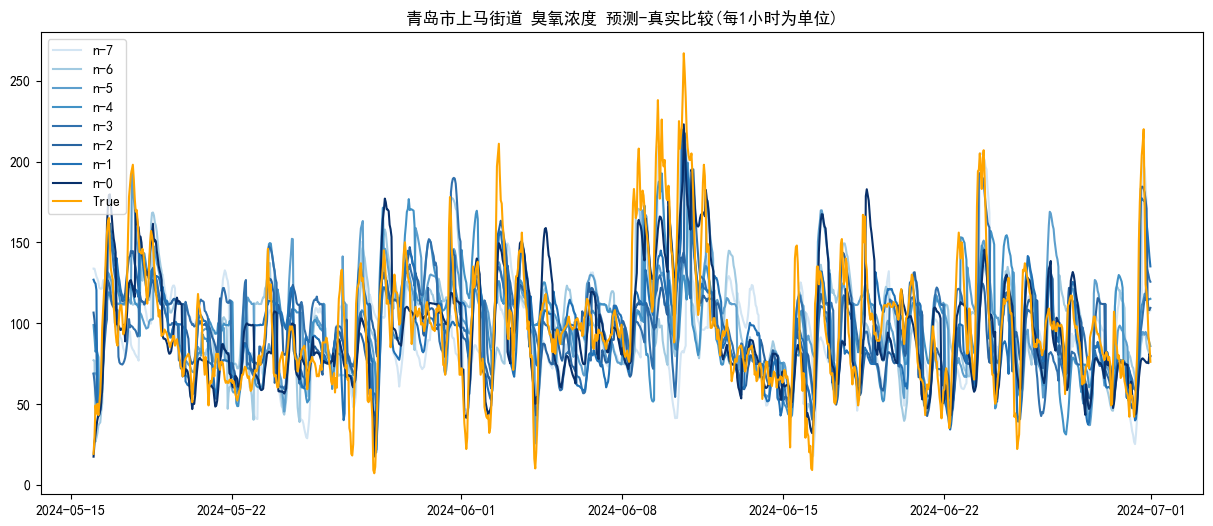

n-7 MASE: 38.56506639017752
n-7 R2: 0.04184846028807776
n-6 MASE: 35.41471557834814
n-6 R2: 0.1919959238787251
n-5 MASE: 33.96185422662273
n-5 R2: 0.2569315495375085
n-4 MASE: 34.6785442670737
n-4 R2: 0.22523899833837824
n-3 MASE: 34.29822004738159
n-3 R2: 0.24213962607768136
n-2 MASE: 29.99441799242665
n-2 R2: 0.42040195238251743
n-1 MASE: 29.220500743703393
n-1 R2: 0.4499257145998271
n-0 MASE: 27.78980927572695
n-0 R2: 0.5024724119471875


In [18]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.dates as mdates
from datetime import datetime, timedelta
date_range_list = []
start_date111 = datetime(2024, 5, 16, 0, 0, 0) 
end_date111 = datetime(2024, 6, 30, 23, 0, 0)
true_value_list = []
date_range111 = pd.date_range(start=start_date111, end=end_date111, freq='H')
merged_data = pd.merge(pd.DataFrame(date_range111, columns=['日期']), datat, on='日期', how='inner')

true_value_list = merged_data['O3VAL'].tolist()

start_date = datetime(2024, 5, 16, 0, 0, 0) 
end_date = datetime(2024, 5, 16, 23, 0, 0)
while end_date < datetime(2024, 7, 1, 0, 0, 0):
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    date_range_list.append(date_range)
    end_date += timedelta(hours=1)
    start_date = end_date
    end_date += timedelta(days=1)
    end_date -= timedelta(hours=1)

num = 0
colors = [
 '#d3e5f3','#a1cae1', 
    '#5d9fcd', '#4292c6',  '#3171ad',
    '#2864a0', '#2171b5',   '#08306b','orange'
]
true_legend_added = 0 
pred_value_list_7 = np.array([])
pred_value_list_6 = np.array([])
pred_value_list_5 = np.array([])
pred_value_list_4 = np.array([])
pred_value_list_3 = np.array([])
pred_value_list_2 = np.array([])
pred_value_list_1 = np.array([])
pred_value_list_0 = np.array([])

for date_ranges in date_range_list:
    num = 7
    for i in range(len(df_list)):
        is_in_list = df_list[i]['日期'].isin(date_ranges)
        rmse_list = []
        r2_list = []
        if is_in_list.any():
            matching_indices = df_list[i].index[is_in_list].tolist()
            matching_values = df_list[i].loc[is_in_list, '日期'].tolist()
            if num == 7:
                pred_value_list_7 = np.concatenate((pred_value_list_7, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 6:
                pred_value_list_6 = np.concatenate((pred_value_list_6, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 5:
                pred_value_list_5 = np.concatenate((pred_value_list_5, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 4:
                pred_value_list_4 = np.concatenate((pred_value_list_4, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 3:
                pred_value_list_3 = np.concatenate((pred_value_list_3, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 2:
                pred_value_list_2 = np.concatenate((pred_value_list_2, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 1:
                pred_value_list_1 = np.concatenate((pred_value_list_1, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 0:
                pred_value_list_0 = np.concatenate((pred_value_list_0, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            num-=1



plt.figure(figsize=(15, 6))
plt.title("青岛市上马街道 臭氧浓度 预测-真实比较(每1小时为单位)")
plt.plot(date_range111,pred_value_list_7,color=colors[0], label='n-7')
plt.plot(date_range111,pred_value_list_6,color=colors[1], label='n-6')
plt.plot(date_range111,pred_value_list_5,color=colors[2], label='n-5')
plt.plot(date_range111,pred_value_list_4,color=colors[3], label='n-4')
plt.plot(date_range111,pred_value_list_3,color=colors[4], label='n-3')
plt.plot(date_range111,pred_value_list_2,color=colors[5], label='n-2')
plt.plot(date_range111,pred_value_list_1,color=colors[6], label='n-1')
plt.plot(date_range111,pred_value_list_0,color=colors[7], label='n-0')
plt.plot(date_range111,true_value_list,color=colors[-1], label='True')
plt.legend()
plt.show()   


print('n-7 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_7)))
print('n-7 R2:',r2_score(true_value_list, pred_value_list_7))
print('n-6 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_6)))
print('n-6 R2:',r2_score(true_value_list, pred_value_list_6))
print('n-5 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_5)))
print('n-5 R2:',r2_score(true_value_list, pred_value_list_5))
print('n-4 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_4)))
print('n-4 R2:',r2_score(true_value_list, pred_value_list_4))
print('n-3 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_3)))
print('n-3 R2:',r2_score(true_value_list, pred_value_list_3))
print('n-2 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_2)))
print('n-2 R2:',r2_score(true_value_list, pred_value_list_2))
print('n-1 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_1)))
print('n-1 R2:',r2_score(true_value_list, pred_value_list_1))
print('n-0 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_0)))
print('n-0 R2:',r2_score(true_value_list, pred_value_list_0))
# r2_list.append(r2_score(y_list[i].values[int(matching_indices[0]/5):int(matching_indices[(j+1)*24-1]/5)+1], y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[(j+1)*24-1]/5)+1]))
# print(f"第{num}条线,前{j+1}天 rmse:", rmse_list[j])
# print(f"第{num}条线,前{j+1}天 r2 score:", r2_list[j])

In [24]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

rmse_list = []
r2_list = []

for i in range(46):
    mase7 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_7[i*24:i*24+24]))
    mase6 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_6[i*24:i*24+24]))
    mase5 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_5[i*24:i*24+24]))
    mase4 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_4[i*24:i*24+24]))
    mase3 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_3[i*24:i*24+24]))
    mase2 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_2[i*24:i*24+24]))
    mase1 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_1[i*24:i*24+24]))
    mase0 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_0[i*24:i*24+24]))
    r27 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_7[i*24:i*24+24])
    r26 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_6[i*24:i*24+24])
    r25 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_5[i*24:i*24+24])
    r24 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_4[i*24:i*24+24])
    r23 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_3[i*24:i*24+24])
    r22 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_2[i*24:i*24+24])
    r21 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_1[i*24:i*24+24])
    r20 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_0[i*24:i*24+24])
    rmse_list.append(mase7)
    rmse_list.append(mase6)
    rmse_list.append(mase5)
    rmse_list.append(mase4)
    rmse_list.append(mase3)
    rmse_list.append(mase2)
    rmse_list.append(mase1)
    rmse_list.append(mase0)
    11 = np.std(rmse_list)
    r2_list.append(r27)
    r2_list.append(r26)
    r2_list.append(r25)
    r2_list.append(r24)
    r2_list.append(r23)
    r2_list.append(r22)
    r2_list.append(r21)
    r2_list.append(r20)
    std_dev2 = np.std(r2_list)
    col_name1 = 'rmse'
    col_name2 = 'r2'

df = pd.DataFrame({
    'rmse': rmse_list,
    'r2': r2_list
})

# 将 DataFrame 写入 CSV 文件
df.to_csv('metrics_shangma.csv', index=False)

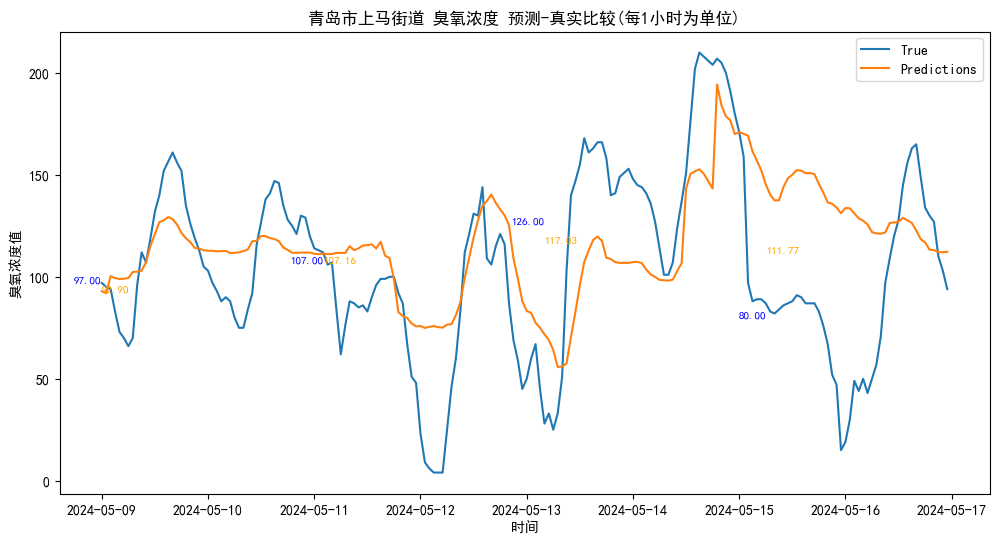

all
rmse: 40.87675161316505
r2 score: 0.17566587049616733
all-1
rmse: 31.972532483285775
r2 score: 0.5214420234309192
all-2
rmse: 31.53369559406798
r2 score: 0.39339078068891997


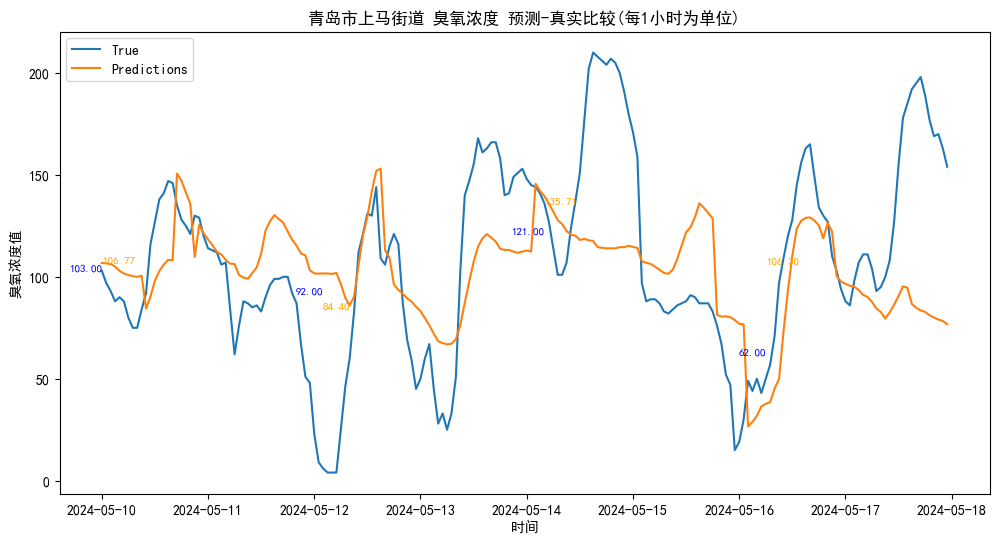

all
rmse: 44.003005168497104
r2 score: 0.13724584569218512
all-1
rmse: 41.26267488858272
r2 score: 0.22770155459062624
all-2
rmse: 42.583578546424555
r2 score: 0.24039599684765856


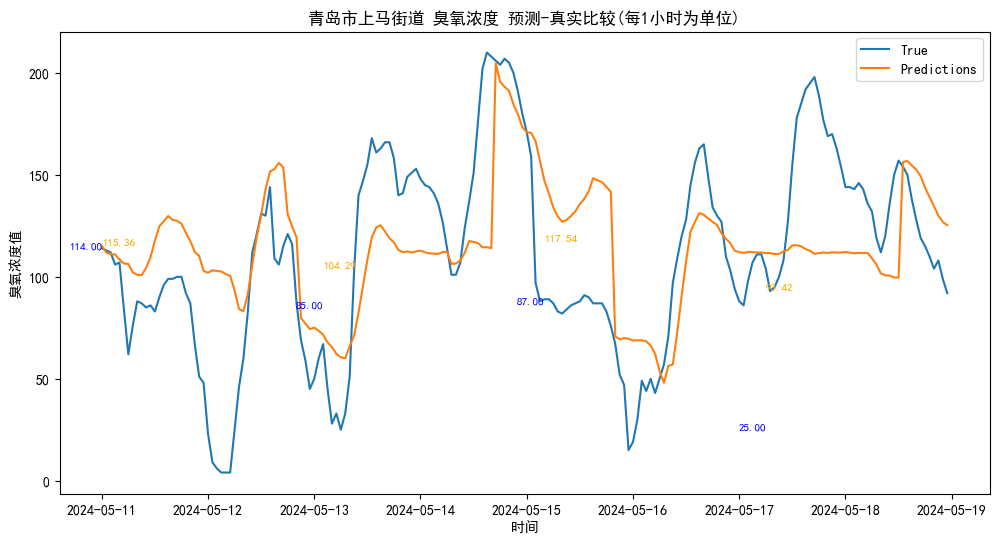

all
rmse: 39.99768740687112
r2 score: 0.2939346613981004
all-1
rmse: 40.118984093508416
r2 score: 0.3415500232689521
all-2
rmse: 42.5190886394882
r2 score: 0.2846776148962986


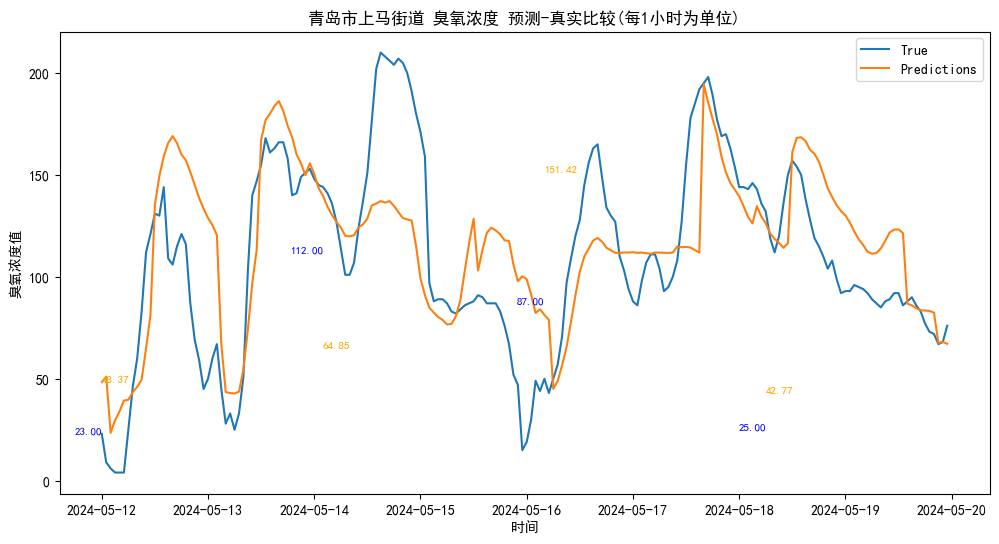

all
rmse: 35.04648047532175
r2 score: 0.4554880514142683
all-1
rmse: 38.025329924681884
r2 score: 0.4792810530927828
all-2
rmse: 39.50108077224244
r2 score: 0.4476406996233876


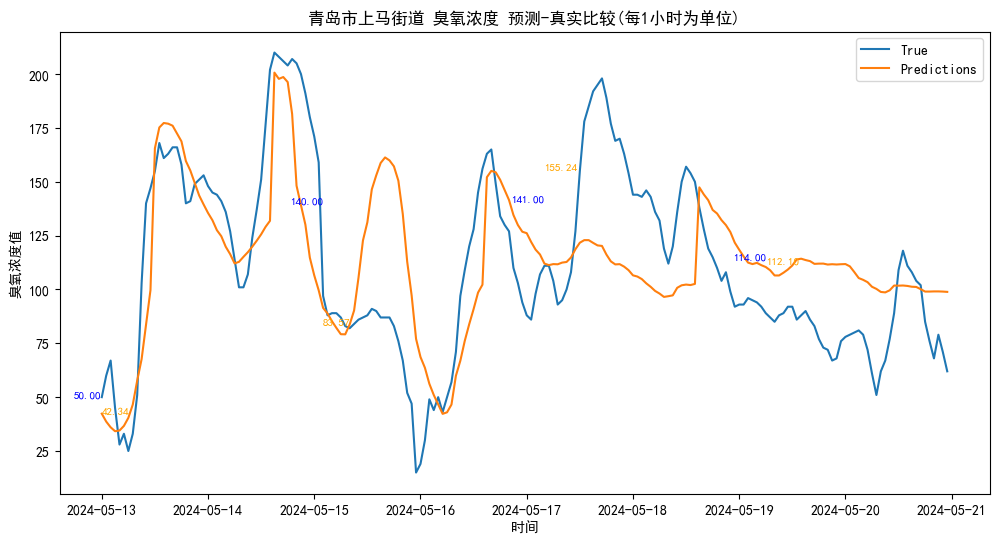

all
rmse: 34.330619844500355
r2 score: 0.38952313577111797
all-1
rmse: 36.427015382411575
r2 score: 0.38783477826120905
all-2
rmse: 36.85948287022916
r2 score: 0.4602092076066875


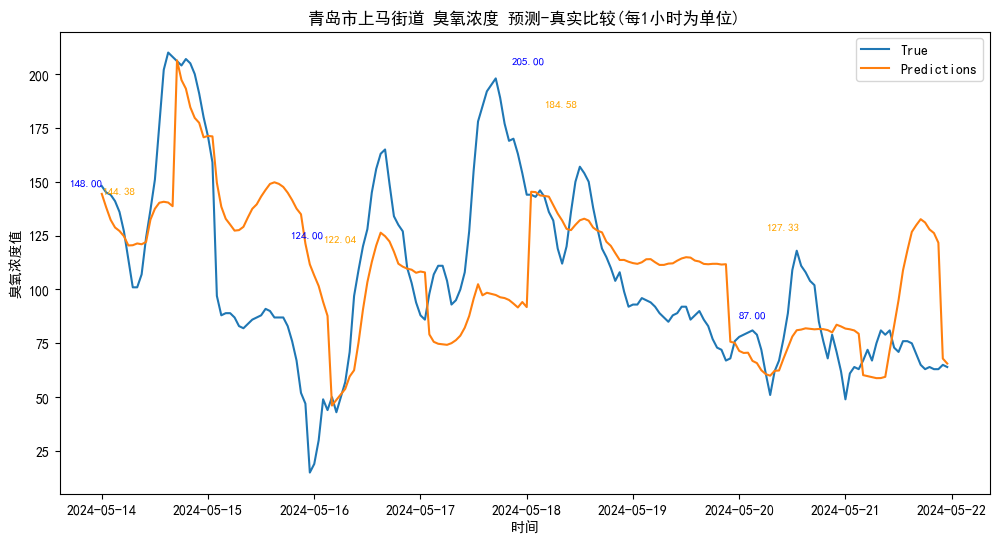

all
rmse: 37.983149778710185
r2 score: 0.18701769280938474
all-1
rmse: 40.5025881569896
r2 score: 0.12070918749852744
all-2
rmse: 42.83103230256952
r2 score: 0.07923303903220658


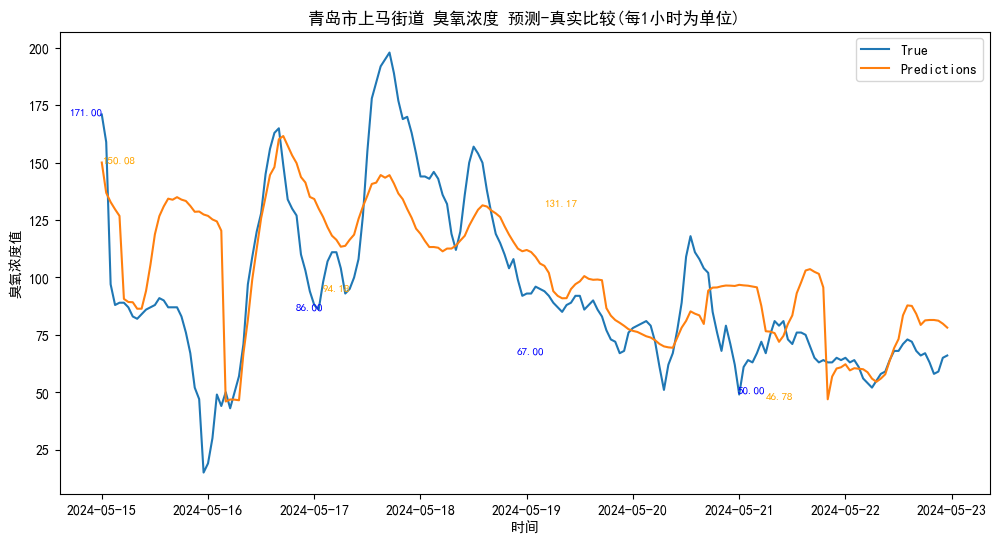

all
rmse: 28.510908313445693
r2 score: 0.3775195665738744
all-1
rmse: 31.05225827452273
r2 score: 0.2974764983500844
all-2
rmse: 33.02217999004967
r2 score: 0.2610916135425312


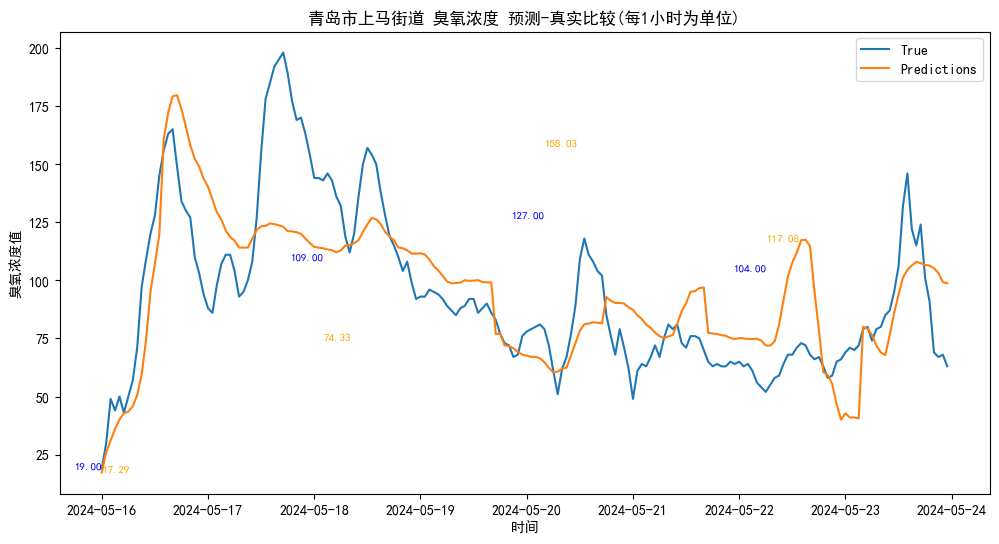

all
rmse: 24.993369579591008
r2 score: 0.5031170396718949
all-1
rmse: 25.175278518791742
r2 score: 0.5408100974778378
all-2
rmse: 26.561565507644847
r2 score: 0.4969989646855796


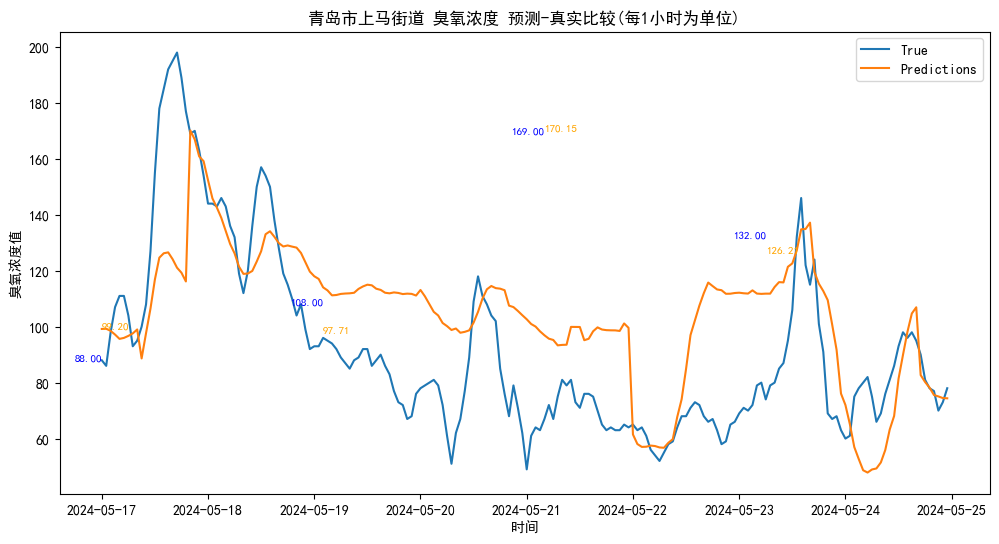

all
rmse: 27.99653918467746
r2 score: 0.24773408882112335
all-1
rmse: 29.33408509794731
r2 score: 0.31164474744002324
all-2
rmse: 29.056679630371782
r2 score: 0.327110978206008


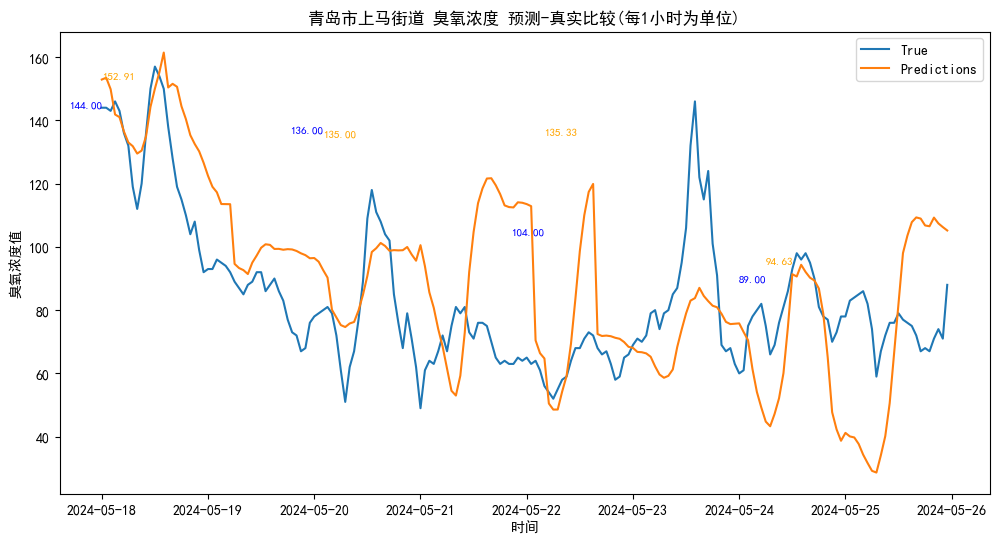

all
rmse: 25.47030686196609
r2 score: -0.1995278285155453
all-1
rmse: 24.26943887608516
r2 score: 0.12498417160687969
all-2
rmse: 24.17084610222674
r2 score: 0.16656000751675026


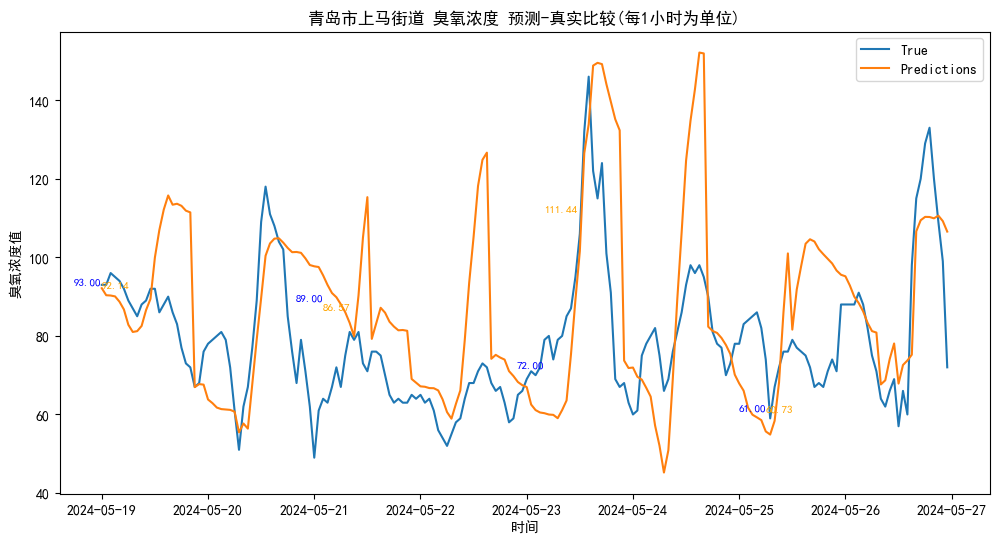

all
rmse: 21.33520773025046
r2 score: -0.6002128034222953
all-1
rmse: 22.25500039503434
r2 score: -0.8352311513754085
all-2
rmse: 21.862327484612198
r2 score: -0.5923232368010642


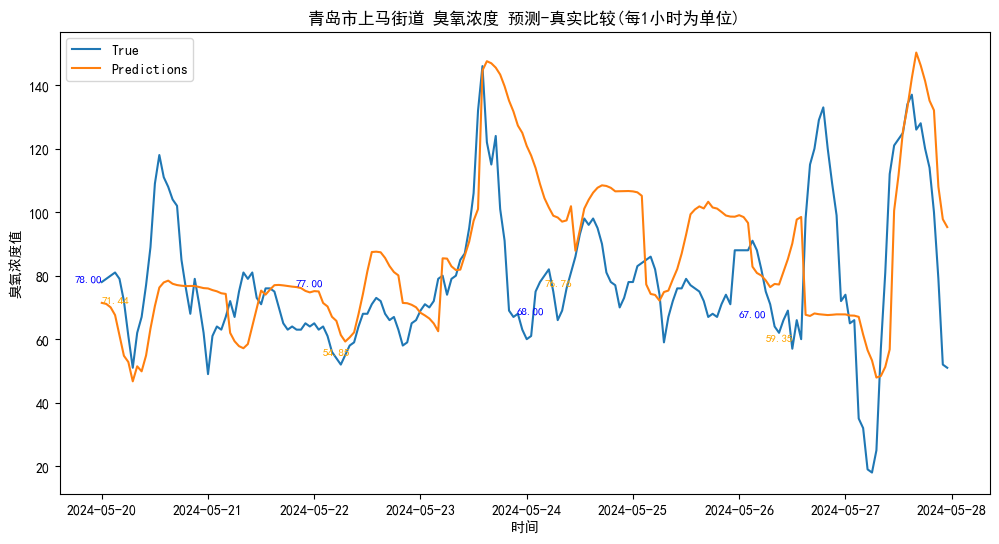

all
rmse: 24.35911435286506
r2 score: -0.2674116454276494
all-1
rmse: 22.38888022873909
r2 score: -0.9634877202675061
all-2
rmse: 22.502851787275272
r2 score: -0.7085826611483641


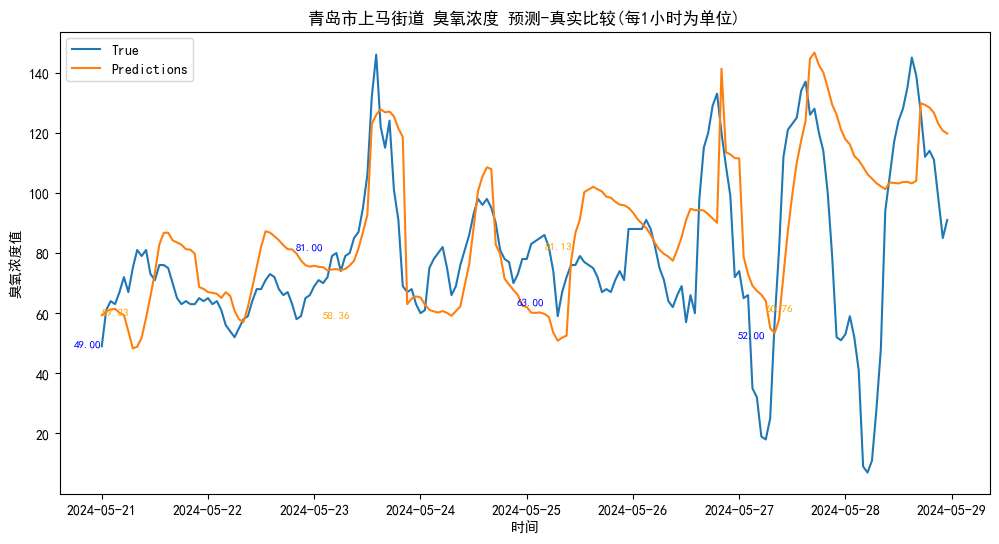

all
rmse: 26.22143193578164
r2 score: -0.032609793282063926
all-1
rmse: 16.75643916680128
r2 score: 0.07776137475454958
all-2
rmse: 15.678162168268072
r2 score: -0.03852028085349746


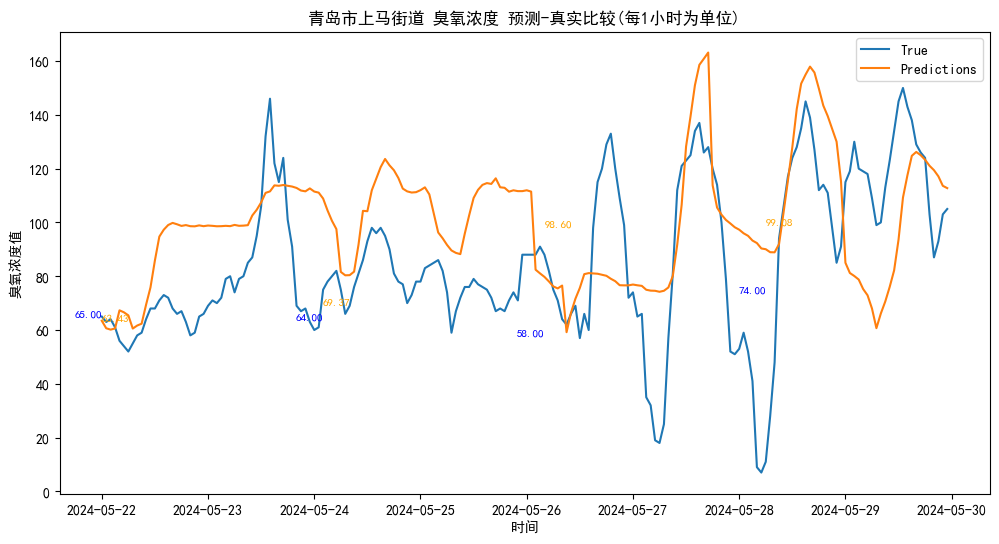

all
rmse: 30.757863236591426
r2 score: -0.13216691852239015
all-1
rmse: 27.716421611076445
r2 score: -0.4132249835959605
all-2
rmse: 27.193001499707822
r2 score: -1.1999211118775817


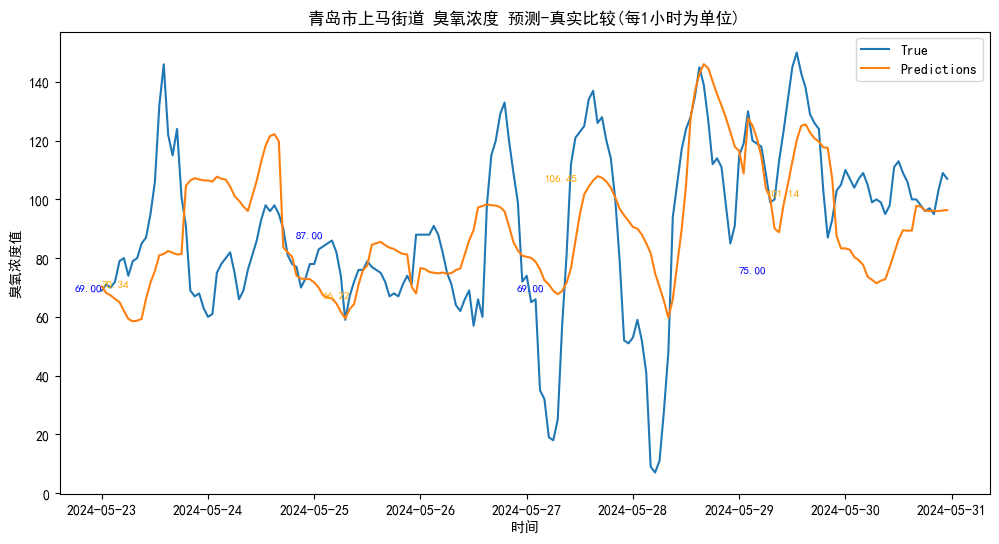

all
rmse: 24.7199603496933
r2 score: 0.22593691185107356
all-1
rmse: 26.357026657637988
r2 score: 0.12546491666919213
all-2
rmse: 24.443354503312534
r2 score: -0.031158990331667358


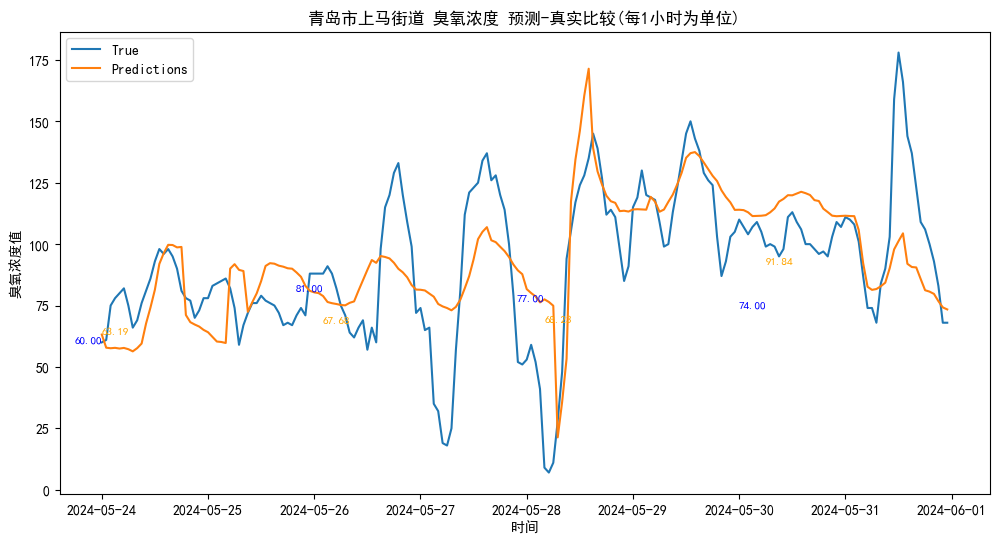

all
rmse: 22.762168779668652
r2 score: 0.40335995344434505
all-1
rmse: 22.537985570493326
r2 score: 0.45288416485900906
all-2
rmse: 24.008281418426716
r2 score: 0.3138787604434683


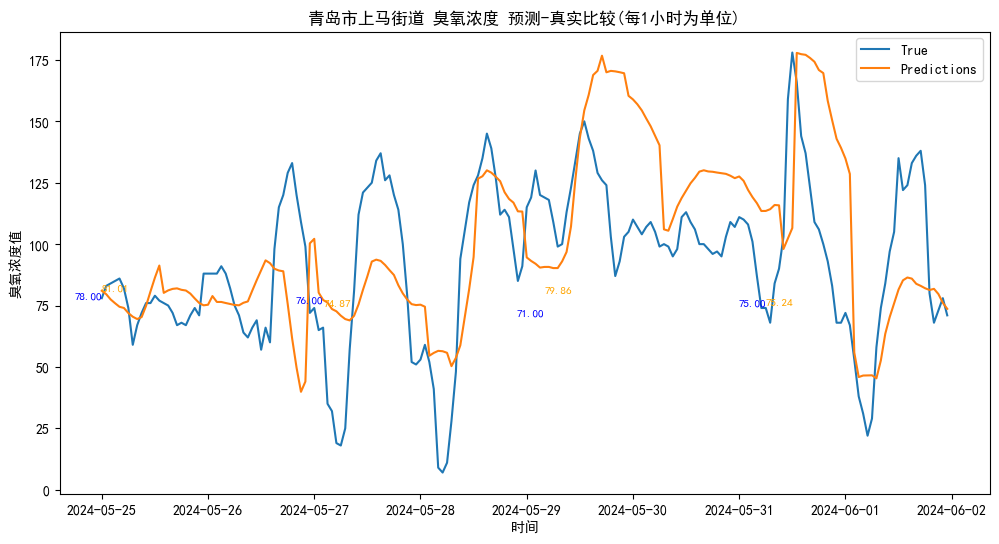

all
rmse: 33.58432961152449
r2 score: -0.1258407795114258
all-1
rmse: 30.474577004936183
r2 score: -0.004385348553742174
all-2
rmse: 30.370887943763268
r2 score: 0.14135851093312535


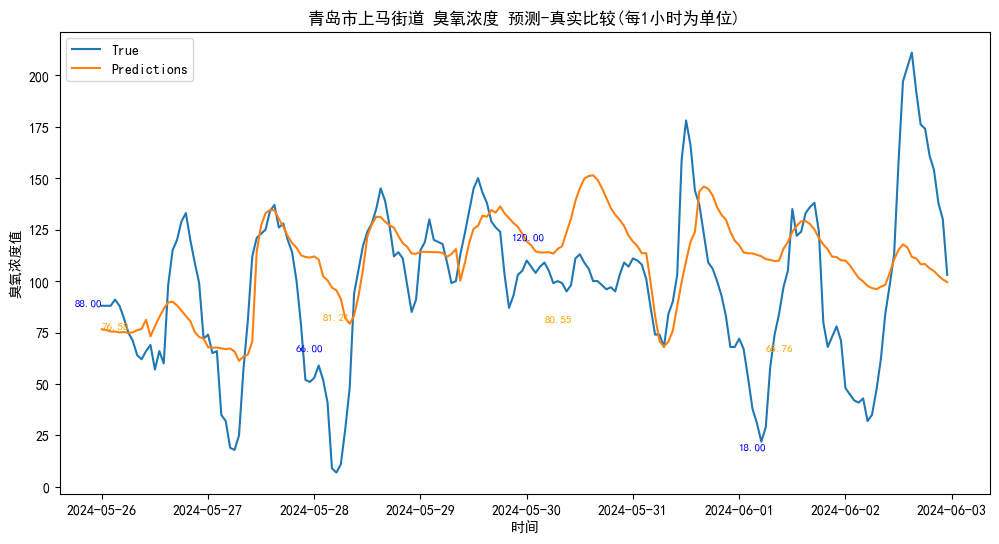

all
rmse: 36.4773497019406
r2 score: 0.08466916509544564
all-1
rmse: 29.778460431485115
r2 score: 0.14080032359310812
all-2
rmse: 29.128672863877195
r2 score: 0.17770866870804192


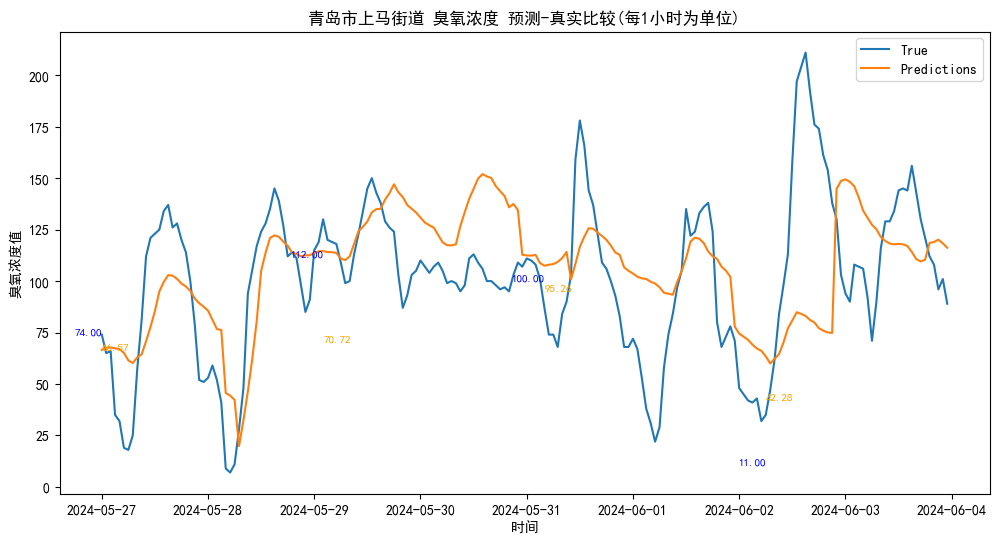

all
rmse: 36.550318097674705
r2 score: 0.08879981425194317
all-1
rmse: 29.42863581220874
r2 score: 0.2620166386735302
all-2
rmse: 27.8745898762508
r2 score: 0.30357091724340834


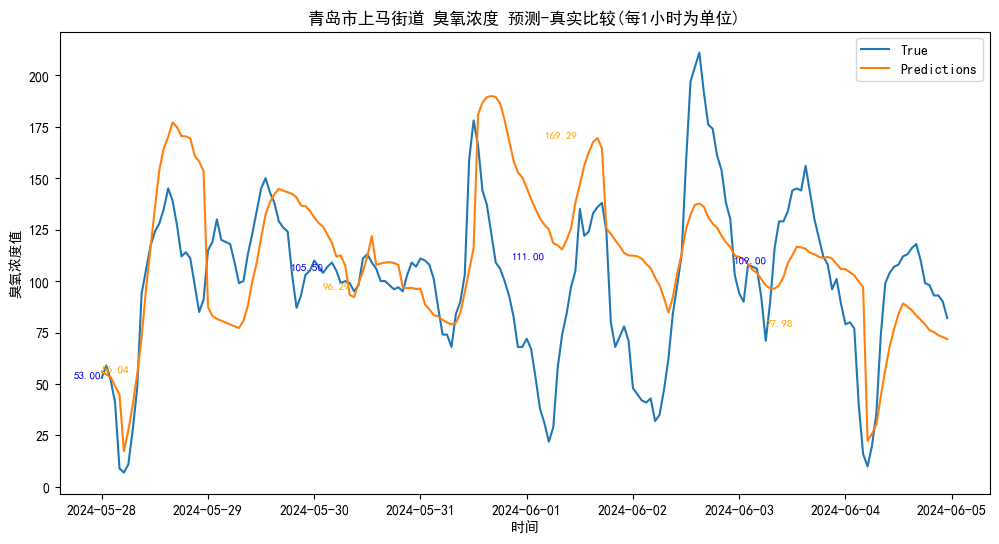

all
rmse: 38.86569917879599
r2 score: -0.07424617021062718
all-1
rmse: 42.153035942288845
r2 score: -0.16364084840858628
all-2
rmse: 40.542252514528634
r2 score: -0.563803233162294


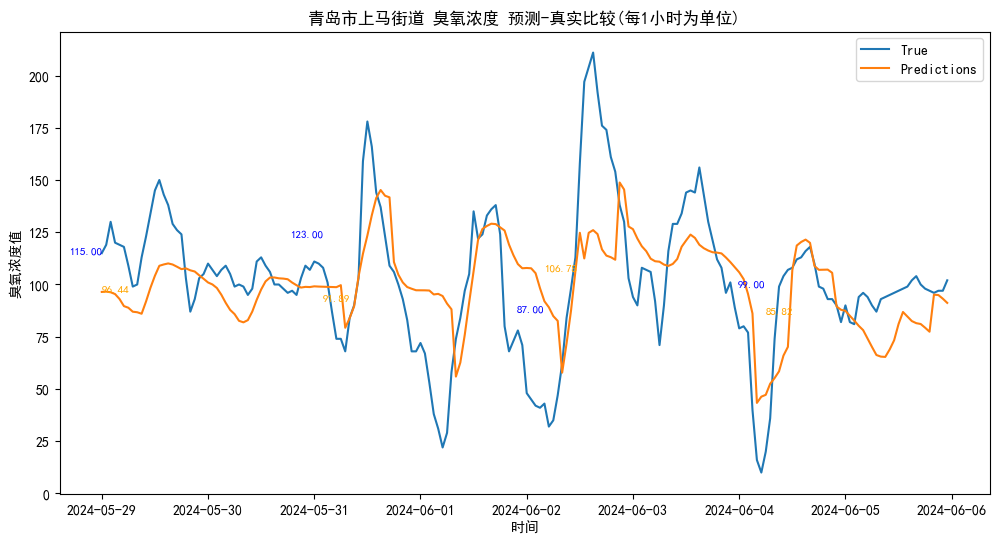

all
rmse: 28.29714934924871
r2 score: 0.302100565356227
all-1
rmse: 30.535385047912765
r2 score: 0.2574813483039592
all-2
rmse: 32.16733532688231
r2 score: 0.2568959808707839


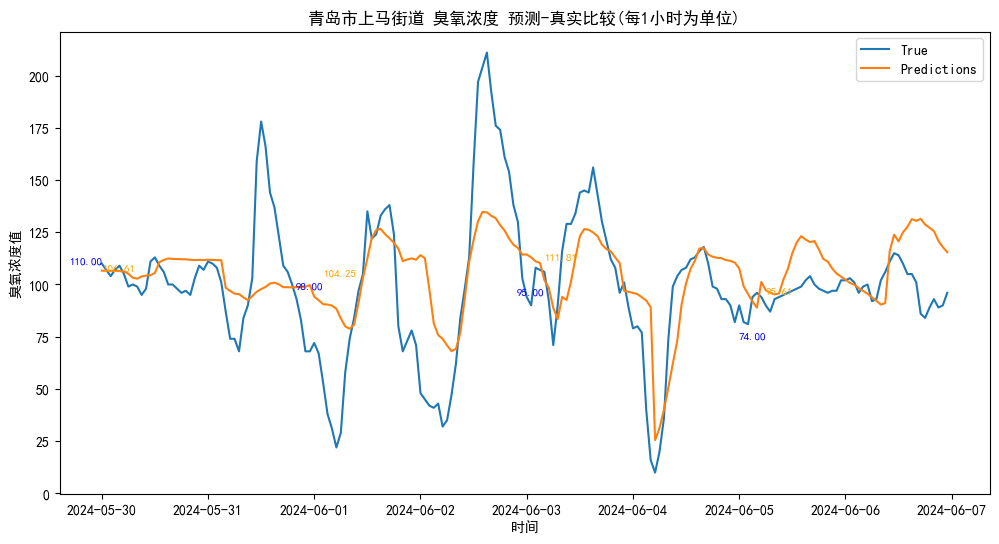

all
rmse: 26.417005223394735
r2 score: 0.3559277231250547
all-1
rmse: 28.586680876762316
r2 score: 0.4258801774306107
all-2
rmse: 29.259309713166008
r2 score: 0.3962213041978102


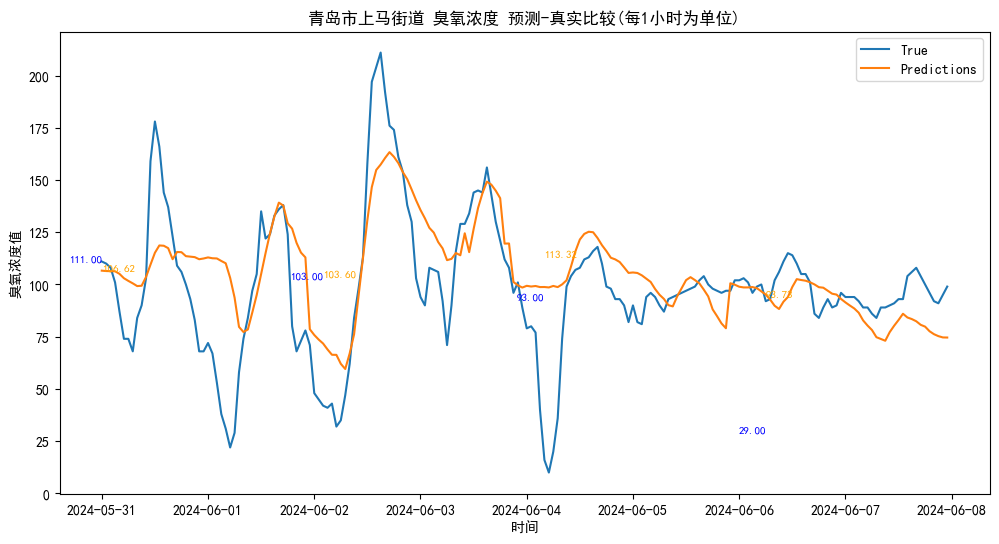

all
rmse: 25.858367060005516
r2 score: 0.3838127678958869
all-1
rmse: 28.93273275789874
r2 score: 0.41266200453753055
all-2
rmse: 31.363069900597402
r2 score: 0.4214689979336457


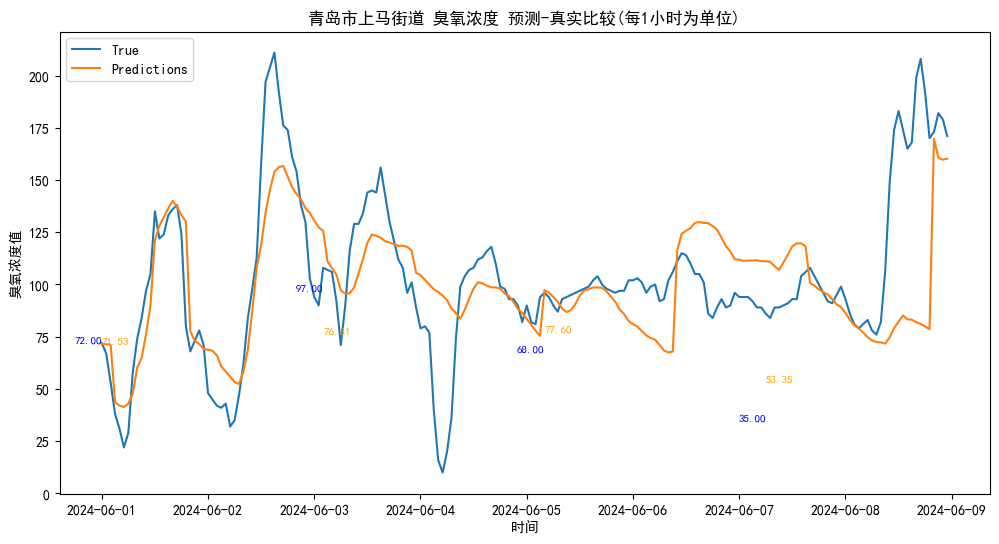

all
rmse: 31.408258876338184
r2 score: 0.31009410366958223
all-1
rmse: 23.9336644718219
r2 score: 0.5492626609759114
all-2
rmse: 23.299930420545028
r2 score: 0.6405189012739957


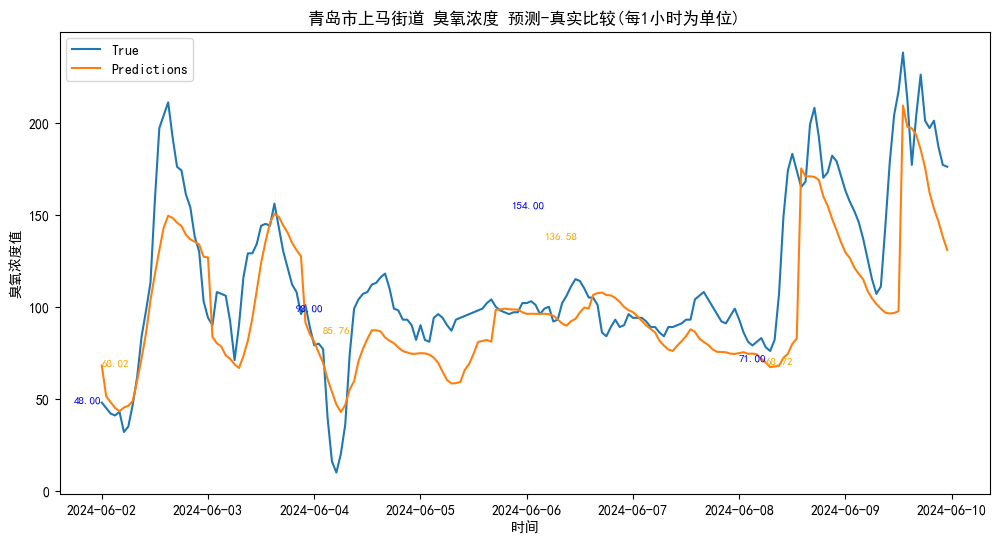

all
rmse: 29.19705860536526
r2 score: 0.5495697175512995
all-1
rmse: 21.600150782295692
r2 score: 0.5480010361220731
all-2
rmse: 22.688663878997787
r2 score: 0.5795156859797395


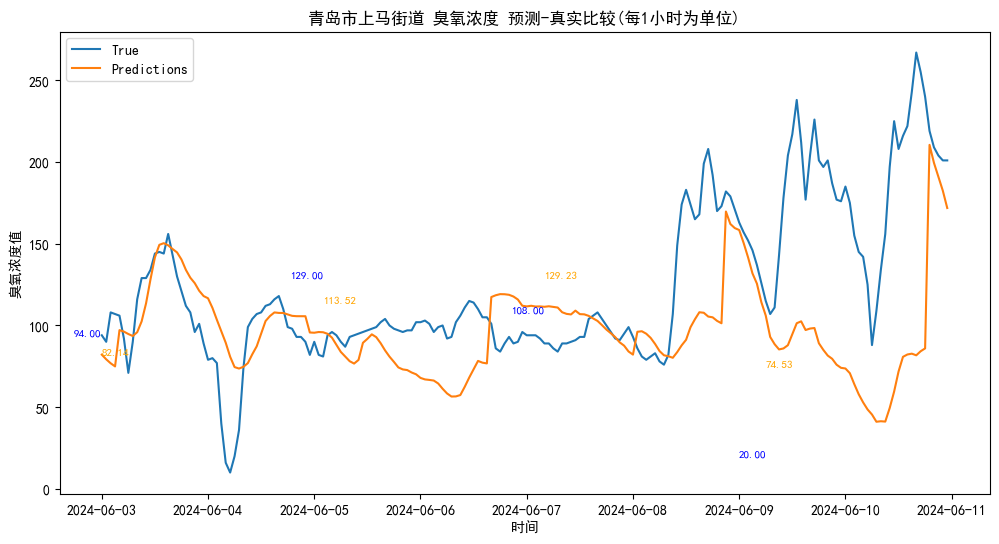

all
rmse: 56.933574631786655
r2 score: -0.4117196441531039
all-1
rmse: 31.602783136509668
r2 score: -0.007803067680704823
all-2
rmse: 24.571218826280546
r2 score: -0.34948209528367524


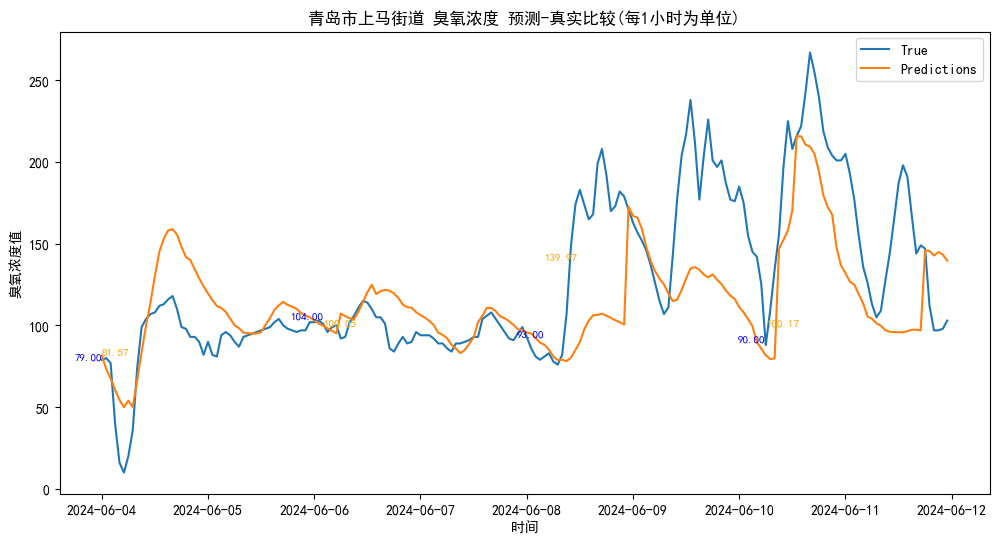

all
rmse: 40.90945051858481
r2 score: 0.3071890651636282
all-1
rmse: 37.40027965495932
r2 score: 0.22843018155637984
all-2
rmse: 31.858268354921382
r2 score: 0.04615385642590897


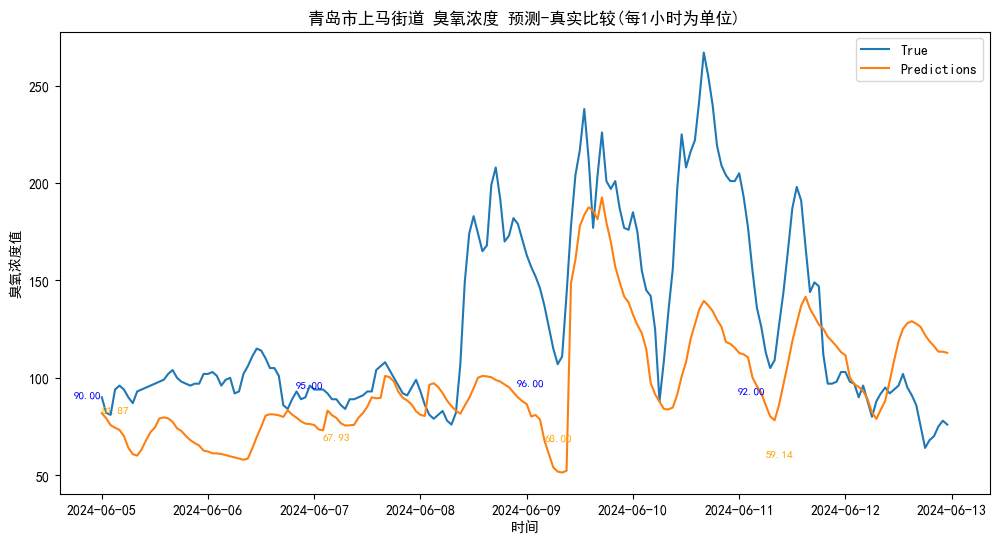

all
rmse: 47.97268094765896
r2 score: -0.02405197811827975
all-1
rmse: 50.74750747339579
r2 score: -0.05349482863368893
all-2
rmse: 41.66886638595831
r2 score: -0.006209821568260665


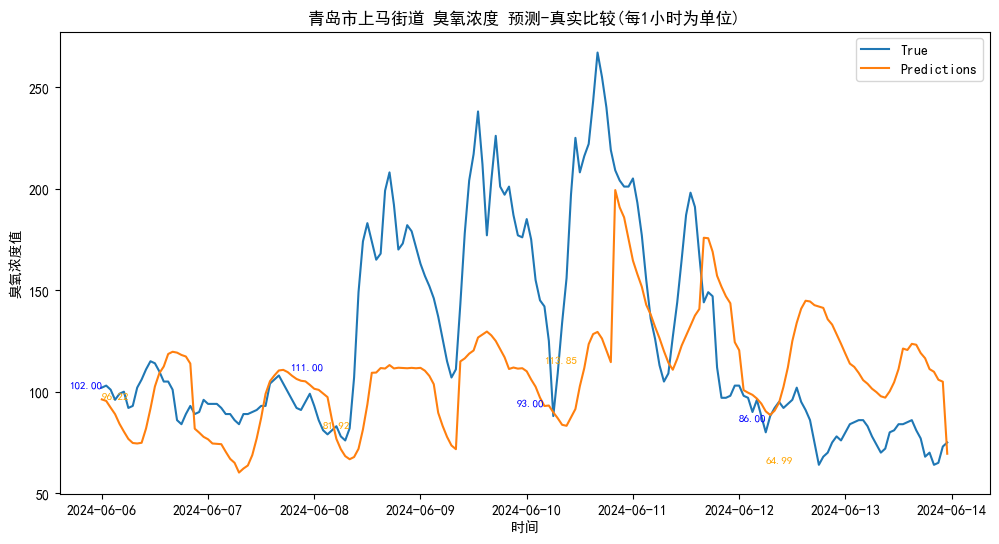

all
rmse: 49.18149315161593
r2 score: 2.1414122287843895e-05
all-1
rmse: 52.66567397814136
r2 score: -0.16682638849514086
all-2
rmse: 55.439185277445794
r2 score: -0.17865434295486327


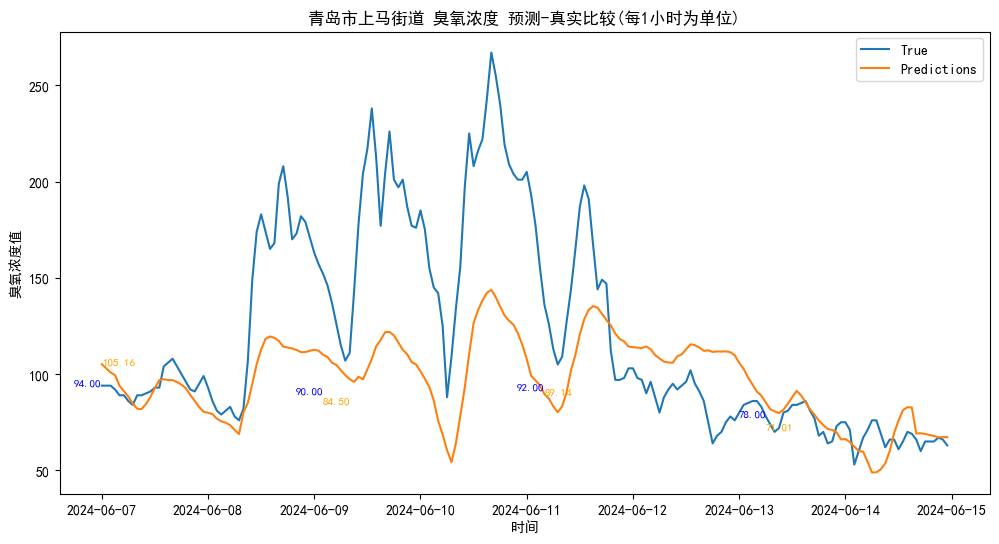

all
rmse: 47.8919329481849
r2 score: 0.1644160057632701
all-1
rmse: 54.95976659145285
r2 score: -0.17553111114435271
all-2
rmse: 59.01732786944759
r2 score: -0.42256749932342186


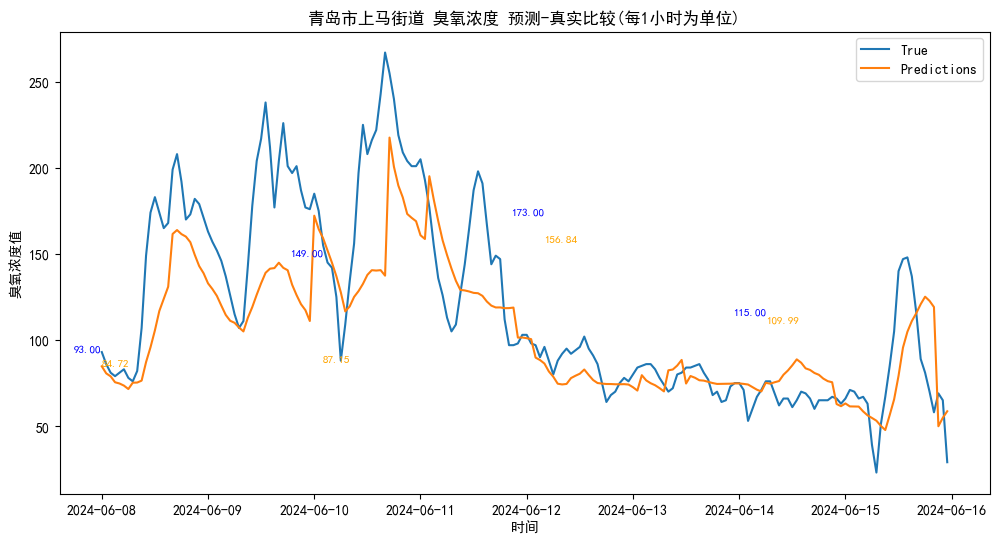

all
rmse: 35.01374388155366
r2 score: 0.5921520464152175
all-1
rmse: 37.93049068404123
r2 score: 0.49391650860503533
all-2
rmse: 41.399160710471556
r2 score: 0.34749257314916215


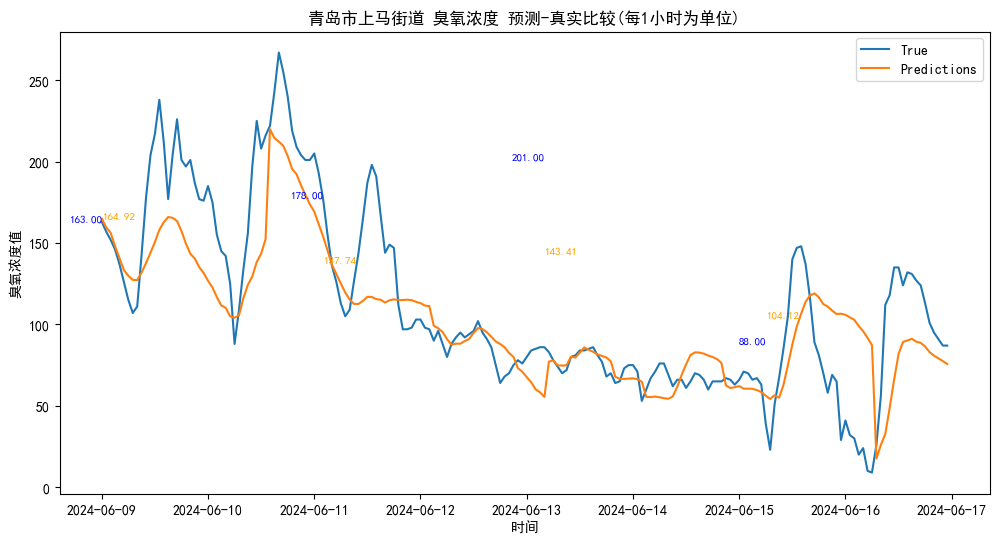

all
rmse: 33.42440715311229
r2 score: 0.6343391474468718
all-1
rmse: 28.928780345572104
r2 score: 0.7302465325070517
all-2
rmse: 31.17442905527628
r2 score: 0.6712834105048393


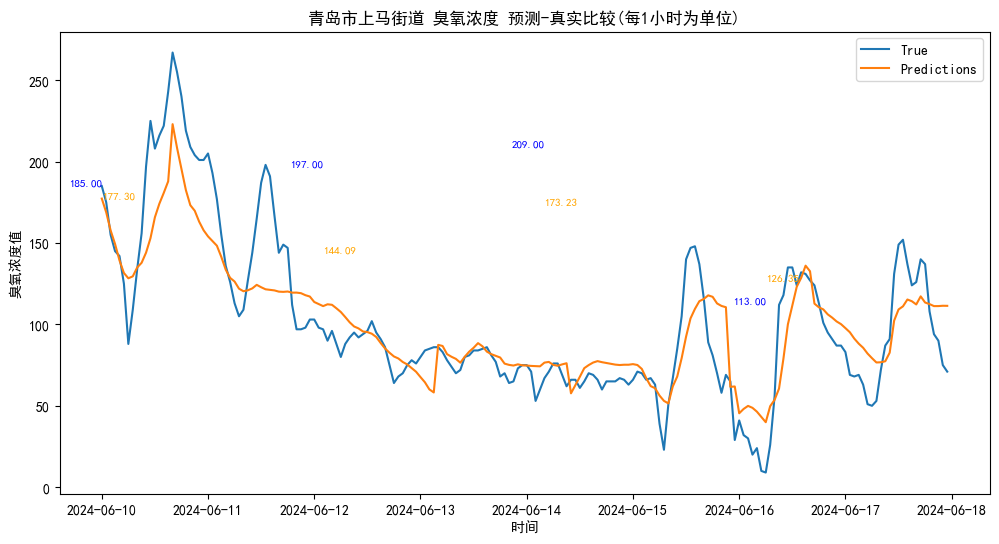

all
rmse: 24.30779543428212
r2 score: 0.7636875100852591
all-1
rmse: 24.635769909049984
r2 score: 0.7766790517413118
all-2
rmse: 24.033649384967728
r2 score: 0.797104942662765


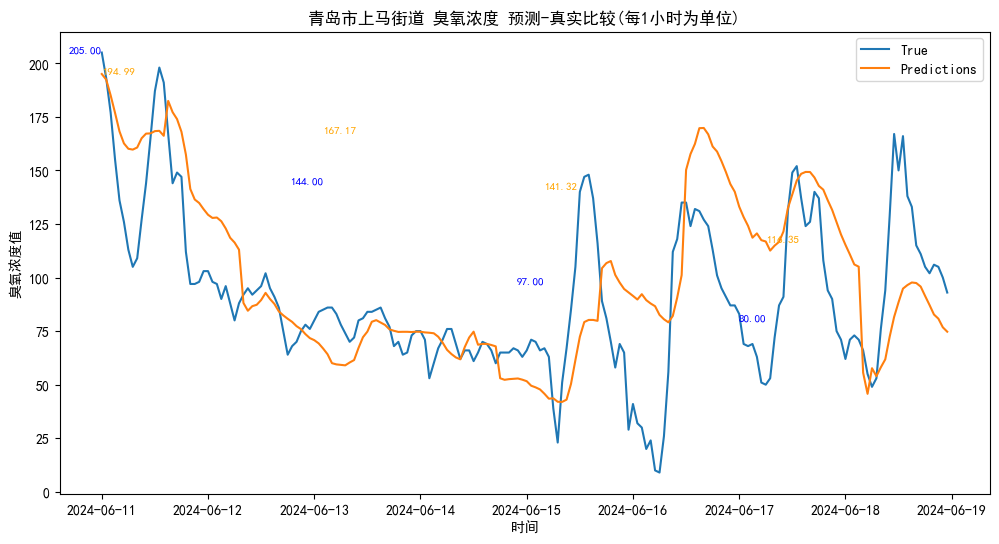

all
rmse: 33.23026775542247
r2 score: 0.1716040538564868
all-1
rmse: 30.766546150776904
r2 score: 0.31904660068238855
all-2
rmse: 24.837526703584338
r2 score: 0.506875573440611


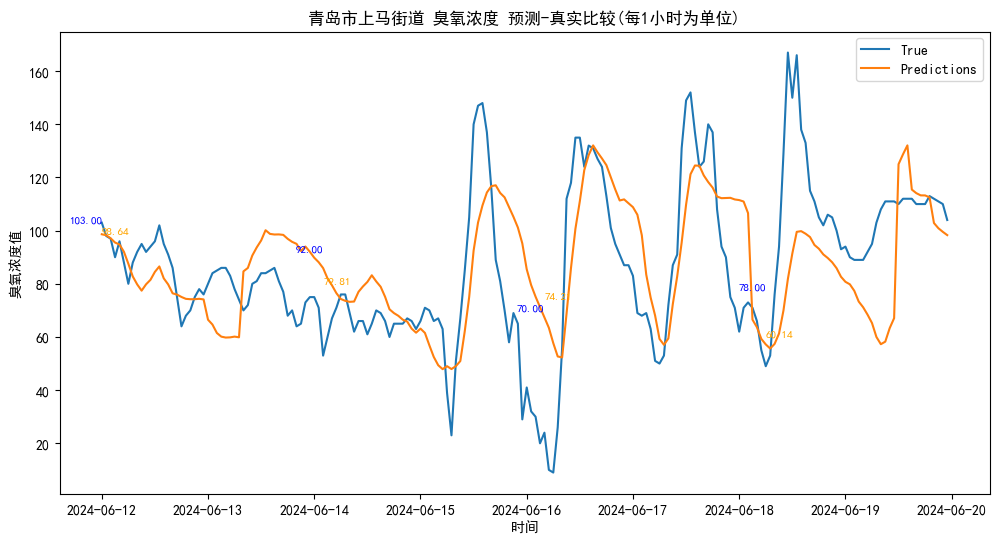

all
rmse: 24.976555892851447
r2 score: 0.2667253171272054
all-1
rmse: 22.830282641474977
r2 score: 0.3649085222262637
all-2
rmse: 22.763719908019905
r2 score: 0.2851103837034179


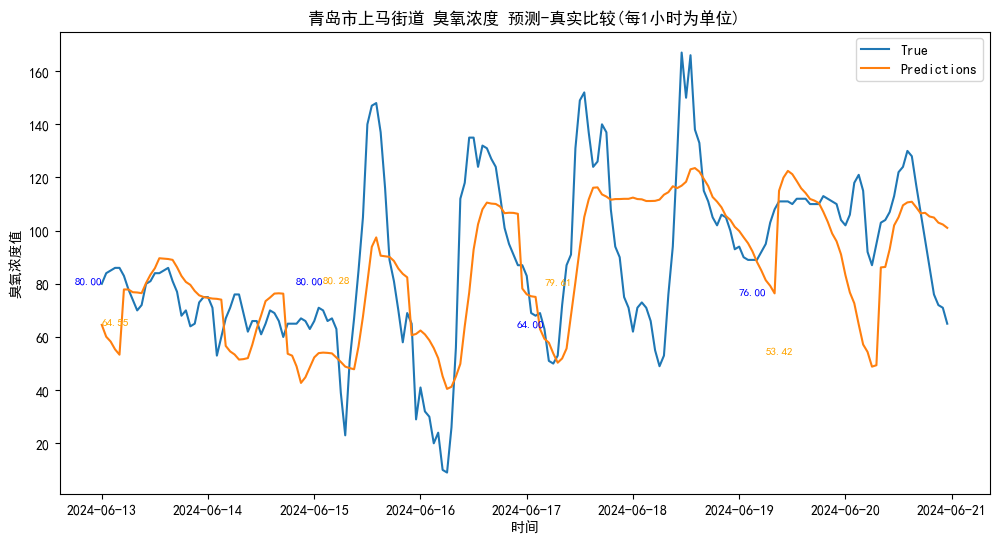

all
rmse: 24.805946775570895
r2 score: 0.3205933233070226
all-1
rmse: 25.515160564127175
r2 score: 0.3730360508169398
all-2
rmse: 23.364164714601515
r2 score: 0.4275822989343435


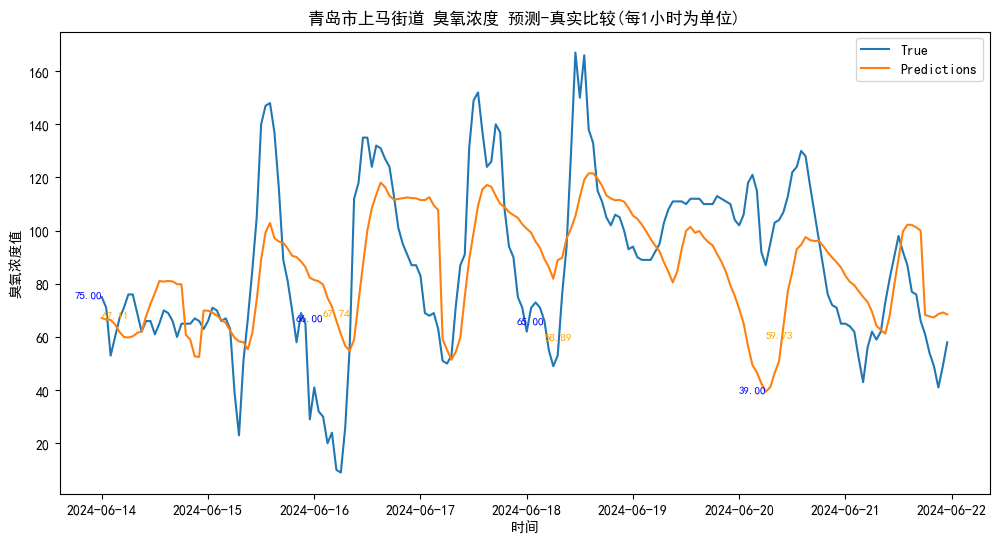

all
rmse: 27.286710188532027
r2 score: 0.23828808006224478
all-1
rmse: 25.74698283441994
r2 score: 0.3932183085959605
all-2
rmse: 26.988834292676064
r2 score: 0.4074292558490106


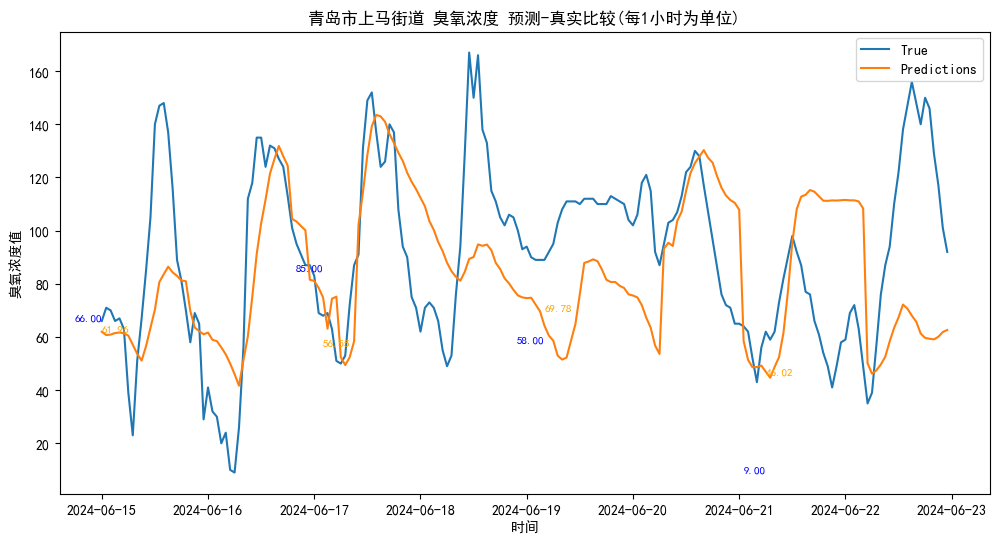

all
rmse: 35.514700122266156
r2 score: -0.13934088003251777
all-1
rmse: 30.402441684323303
r2 score: 0.13274020944323572
all-2
rmse: 30.482925915274535
r2 score: 0.221955540557767


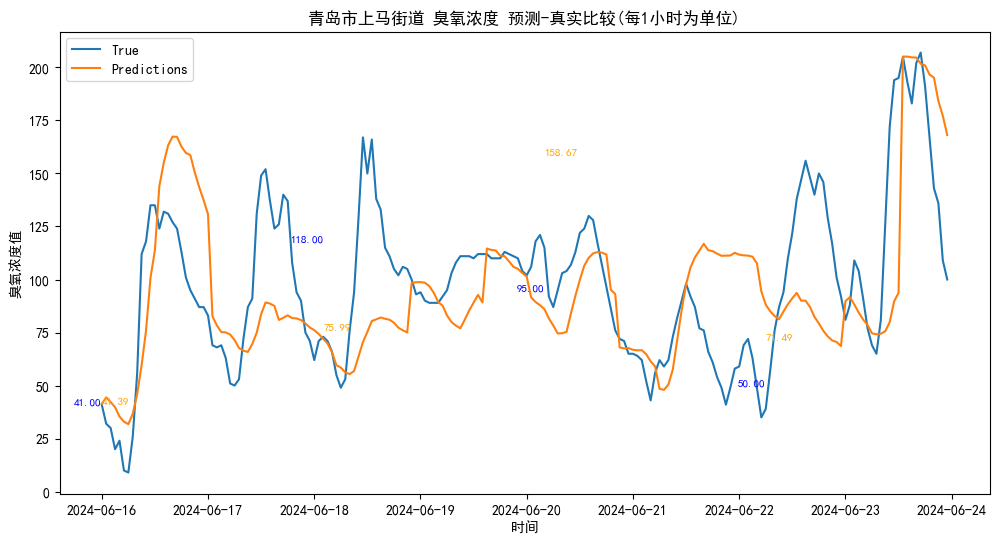

all
rmse: 35.914403709735055
r2 score: 0.11830964124683929
all-1
rmse: 31.734811681618513
r2 score: -0.005506329883228522
all-2
rmse: 31.06948864934376
r2 score: 0.03024179641083702


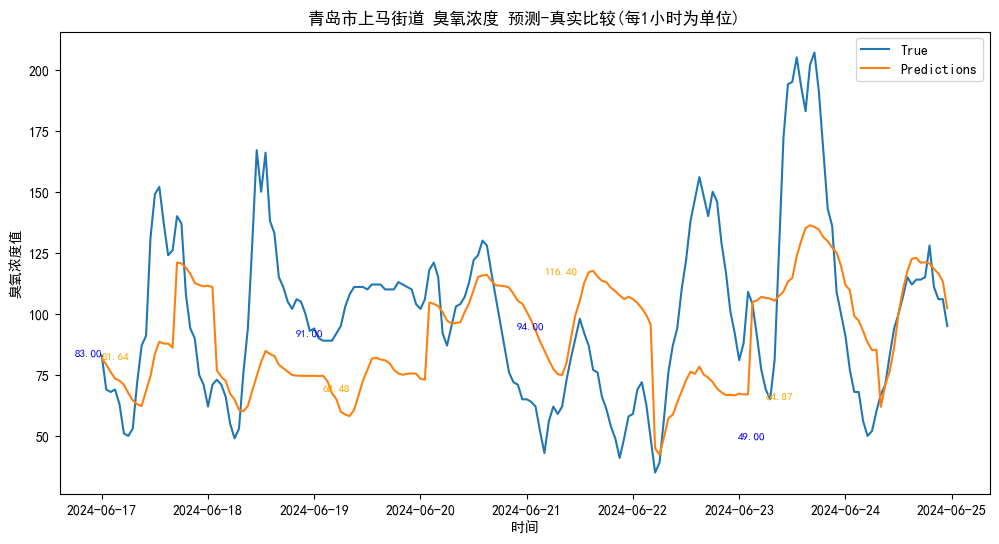

all
rmse: 36.52632560051696
r2 score: -0.06607894715223539
all-1
rmse: 36.835029339794005
r2 score: -0.5150300080042853
all-2
rmse: 33.715394767698555
r2 score: -0.4650399695749621


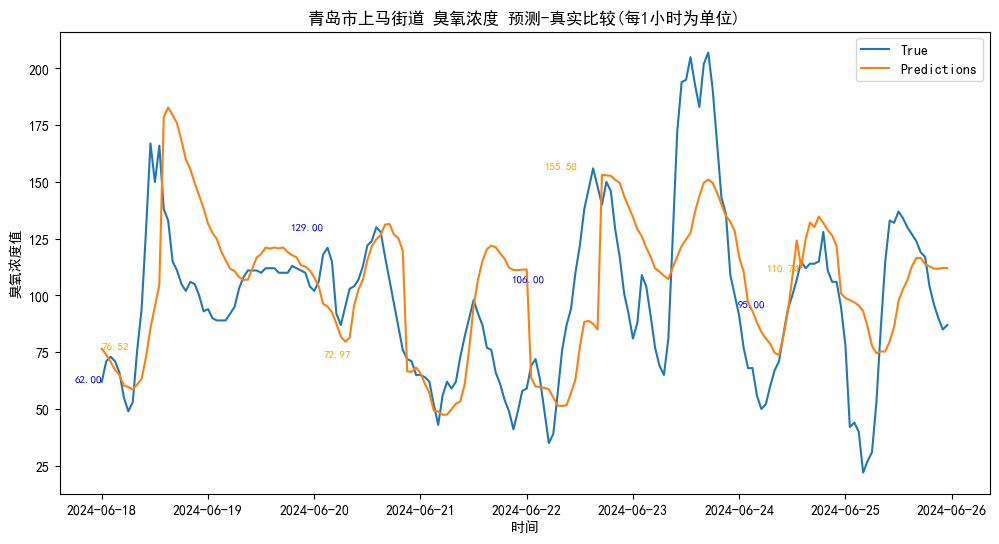

all
rmse: 33.26900485412475
r2 score: 0.1544674897808448
all-1
rmse: 34.4034515783573
r2 score: 0.1421754481345856
all-2
rmse: 32.351155258801526
r2 score: -0.21489625535011325


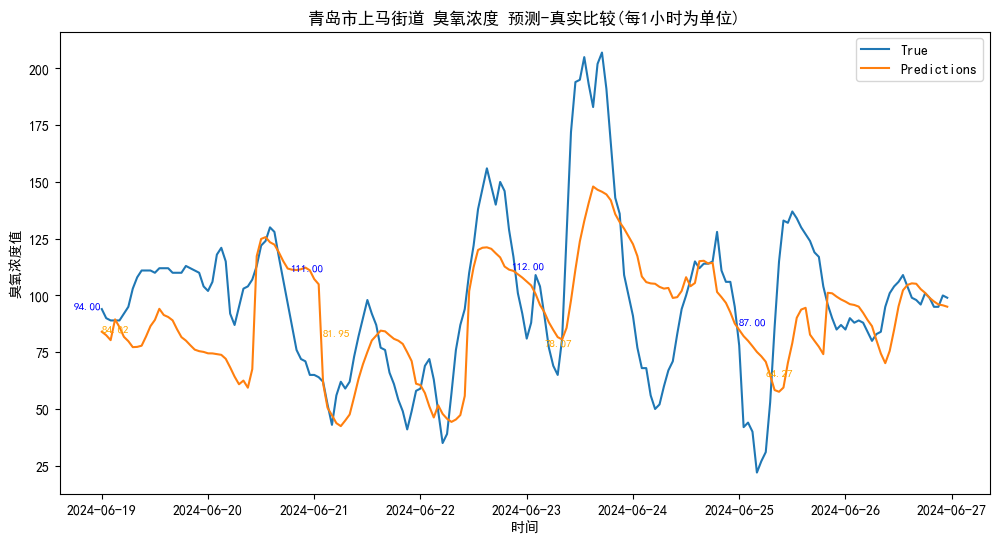

all
rmse: 28.783386948343928
r2 score: 0.29444432012021793
all-1
rmse: 28.685888135110584
r2 score: 0.3651221106993241
all-2
rmse: 28.727937730623985
r2 score: 0.42058028684981685


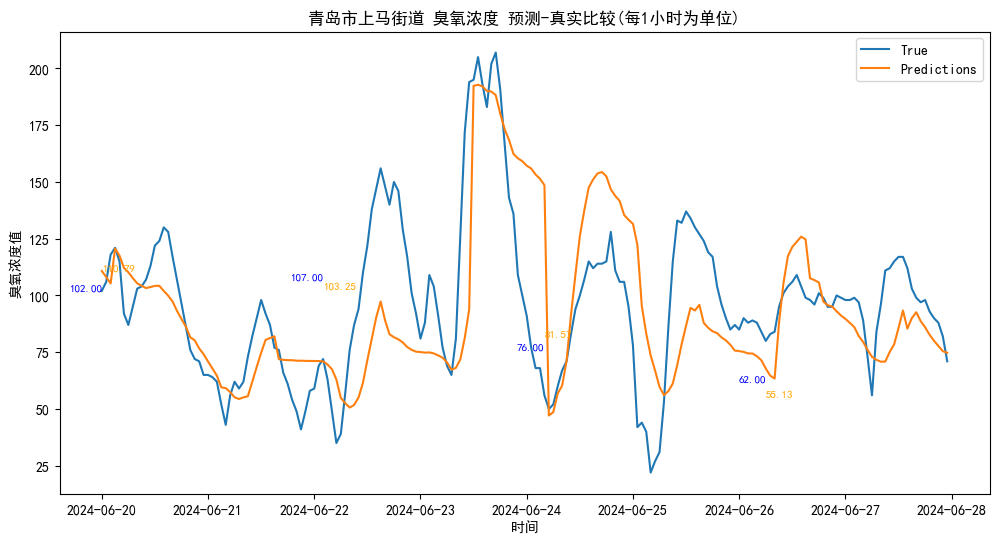

all
rmse: 30.904382567485303
r2 score: 0.19472802951443735
all-1
rmse: 34.372841233649346
r2 score: 0.22913336778792204
all-2
rmse: 32.89671691825704
r2 score: 0.2946654950343659


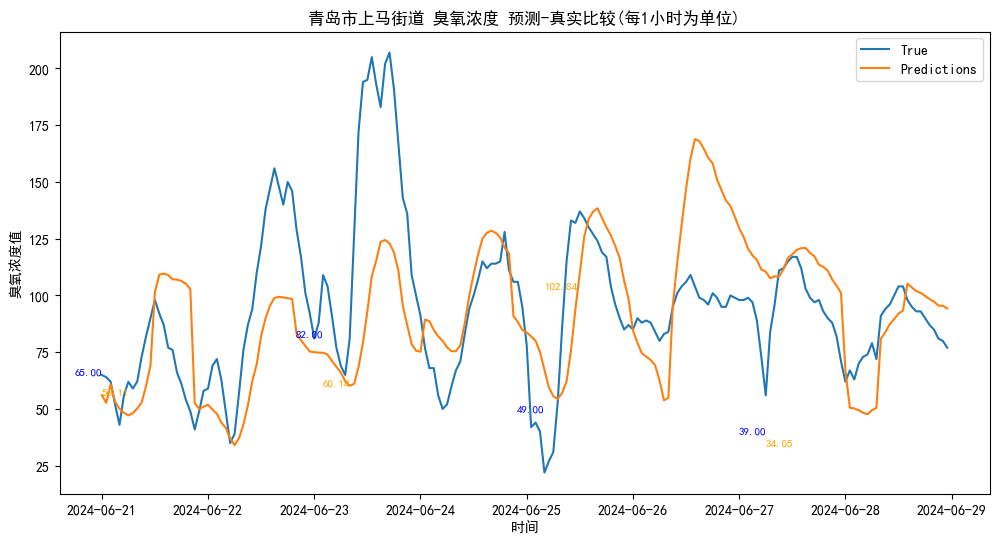

all
rmse: 33.52179219342891
r2 score: 0.04255768040327146
all-1
rmse: 37.043019967654075
r2 score: 0.07435629320298831
all-2
rmse: 36.293779645651824
r2 score: 0.254047775279284


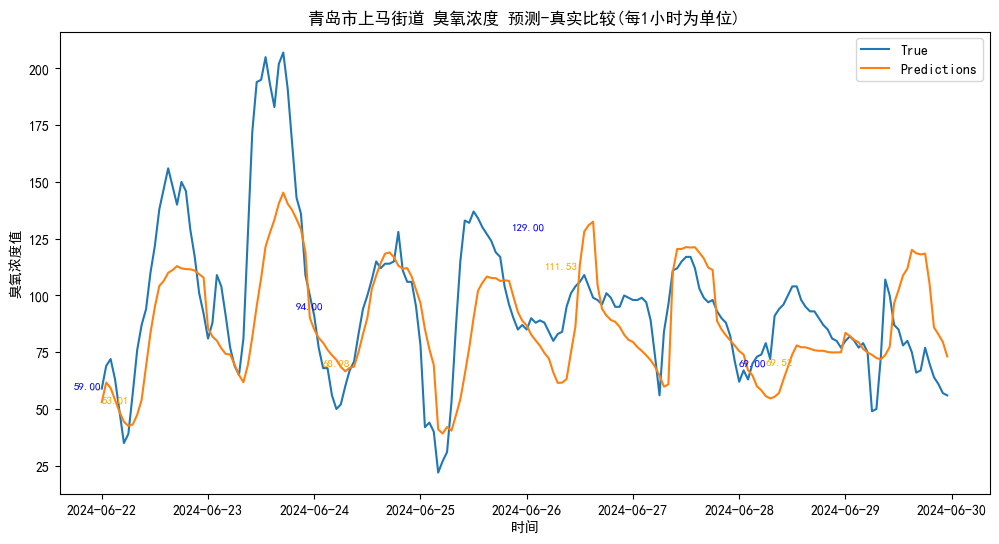

all
rmse: 26.511136179696603
r2 score: 0.3702176715895489
all-1
rmse: 27.39413234797285
r2 score: 0.42340253443225884
all-2
rmse: 29.249397483293052
r2 score: 0.4335194222978984


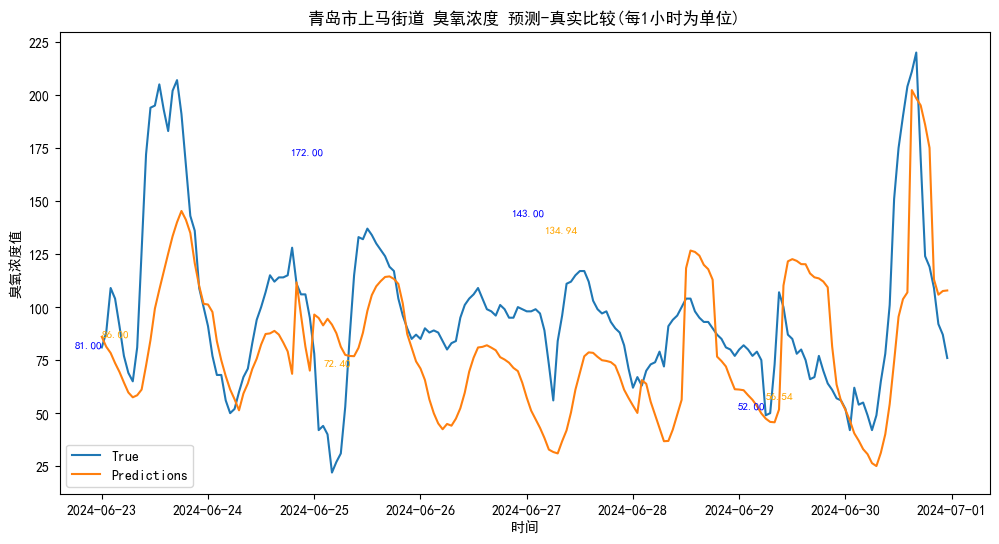

all
rmse: 37.09939716374434
r2 score: -0.005824245398464711
all-1
rmse: 36.59328376051524
r2 score: -0.19204166615174656
all-2
rmse: 38.11298777139619
r2 score: -0.14447930377049145


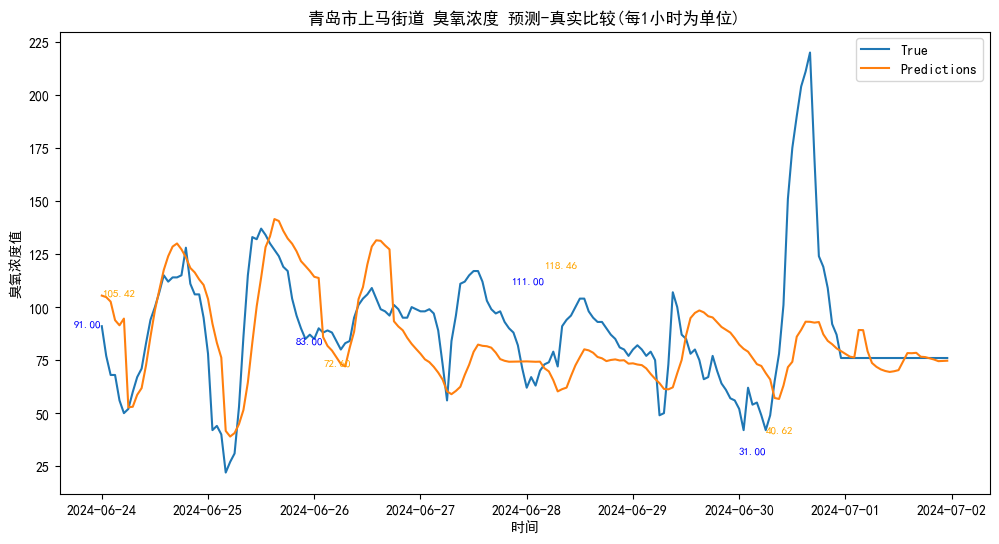

all
rmse: 28.572740084969617
r2 score: 0.041629493823910124
all-1
rmse: 22.049171971796042
r2 score: 0.0064468352316845445
all-2
rmse: 22.144520972970767
r2 score: 0.022836344009361187


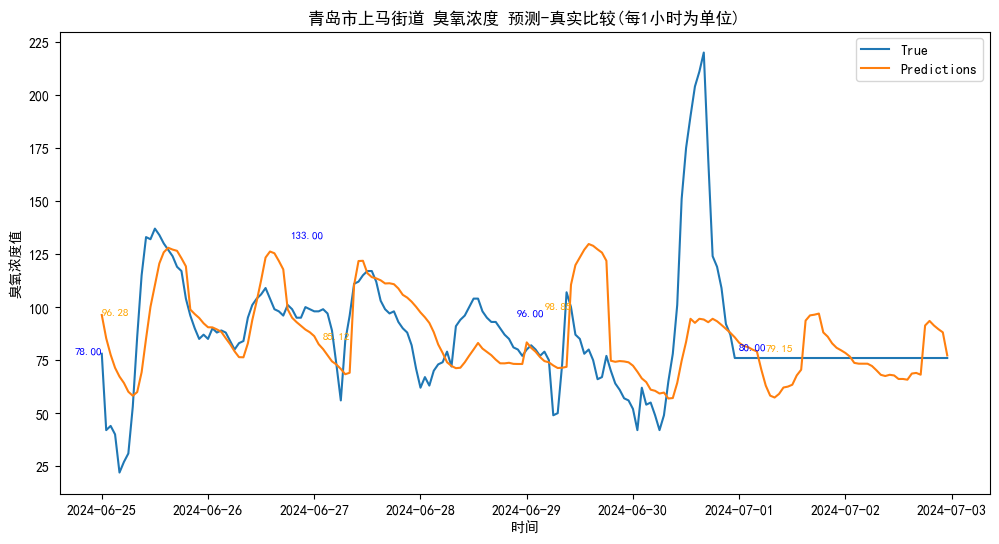

all
rmse: 26.813138391559647
r2 score: 0.1042233020168678
all-1
rmse: 30.31115128745621
r2 score: 0.09399300703374647
all-2
rmse: 21.515849278653487
r2 score: 0.03330304603769929


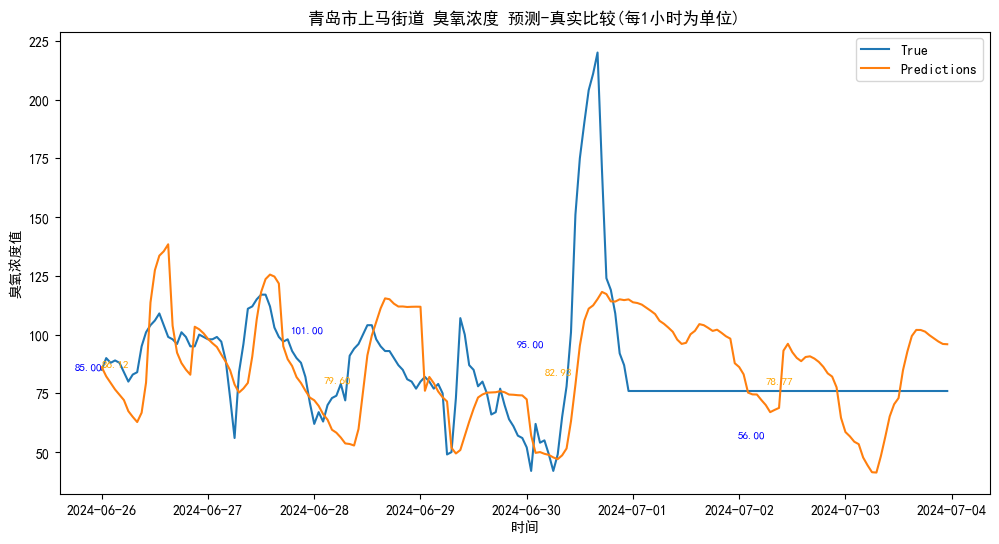

all
rmse: 25.44377044404566
r2 score: -0.022625260655404045
all-1
rmse: 27.524902436652866
r2 score: 0.05749850540764634
all-2
rmse: 27.443215308379667
r2 score: 0.18666208612729251


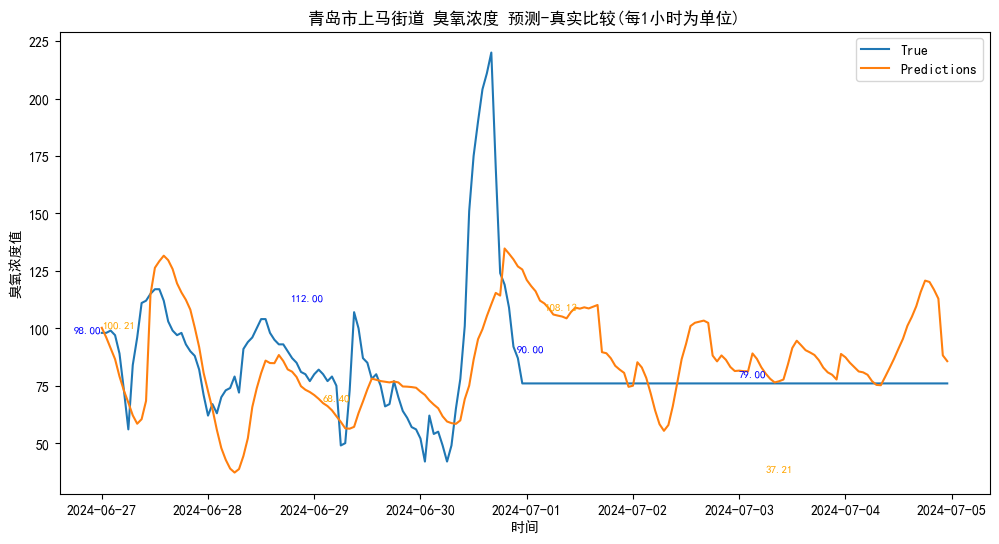

all
rmse: 27.103309924948807
r2 score: -0.18358256631072867
all-1
rmse: 29.61106504799376
r2 score: -0.08974574191249096
all-2
rmse: 31.666327278949417
r2 score: -0.0627860562174738


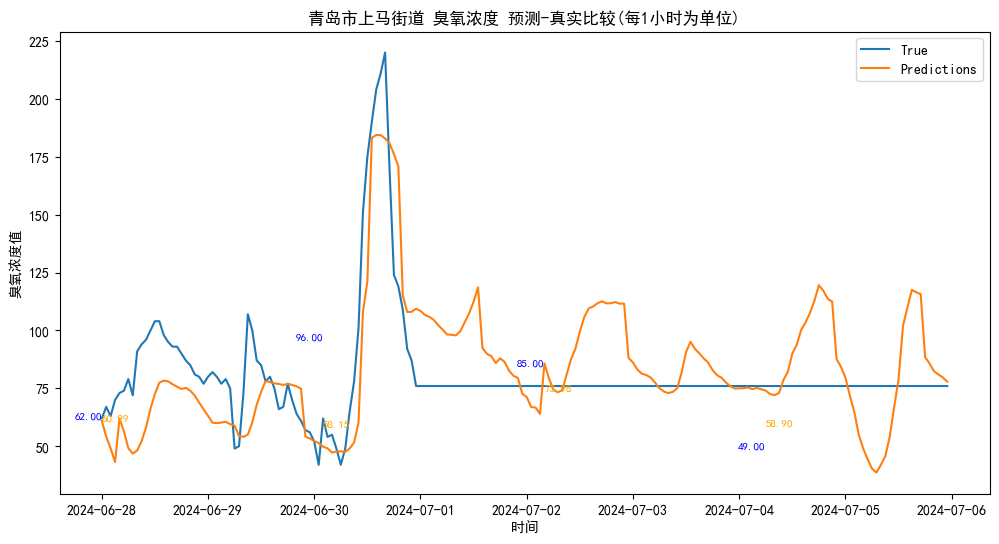

all
rmse: 21.938419189606183
r2 score: 0.16161416703606168
all-1
rmse: 21.5431215931633
r2 score: 0.3856886167413909
all-2
rmse: 23.307194317871208
r2 score: 0.3944284059970852


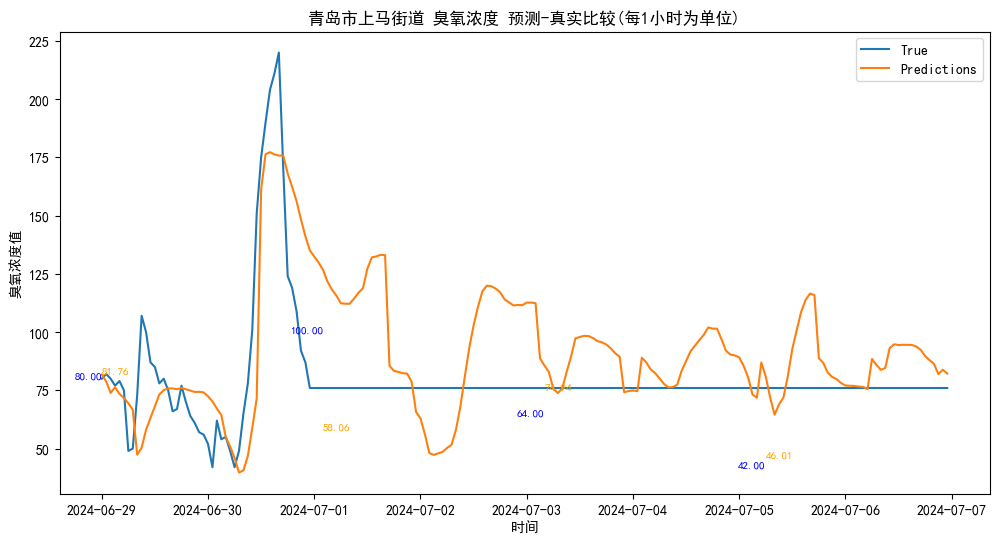

all
rmse: 25.70334453330943
r2 score: -0.1915149104317555
all-1
rmse: 28.33091451368468
r2 score: -0.09452849528979357
all-2
rmse: 30.32832949300133
r2 score: -0.05211179736821614


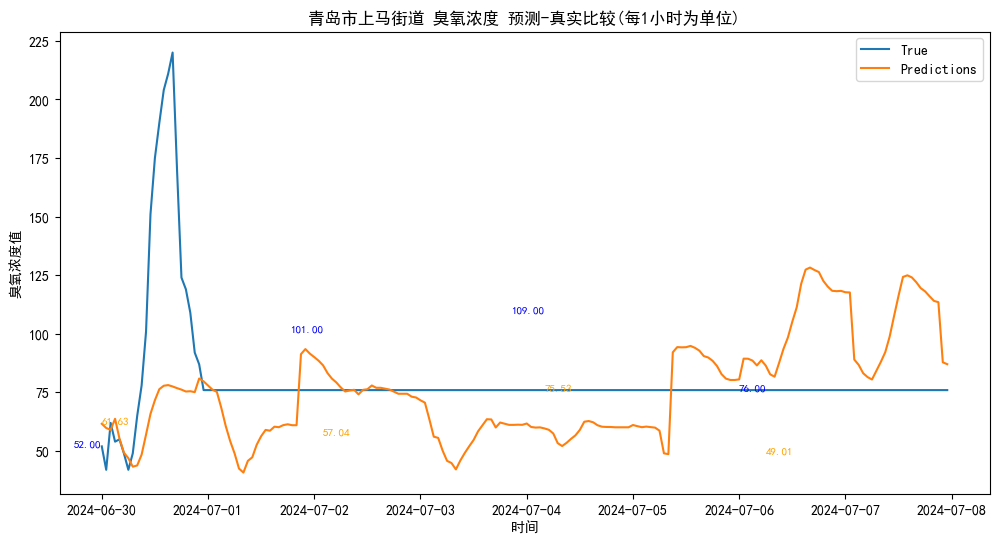

all
rmse: 31.196571137583984
r2 score: -0.841236409012442
all-1
rmse: 30.697693693652457
r2 score: -0.3502112278517475
all-2
rmse: 32.846437277859884
r2 score: -0.2983804721537737


In [23]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
for i in range(len(df_list)):
# 绘制真实值和预测值的曲线
    plt.figure(figsize=(12, 6))
    plt.title("青岛市上马街道 臭氧浓度 预测-真实比较(每1小时为单位)")
    plt.plot(df_list[i]['日期'],y_list[i].values , label='True')
    plt.plot(df_list[i]['日期'],y_pred_list[i] , label='Predictions')
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

# 显示每个具体的数值
    for j in range(0, len(df_list[i]), 10):
        if 5 * j < len(df_list[i]):
            plt.text(df_list[i].iloc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
            plt.text(df_list[i].iloc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')
    plt.legend()
    plt.show()
    print("all")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
    print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))
    print("all-1")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values[:-(2*24)], y_pred_list[i][:-(2*24)])))
    print("r2 score:", r2_score(y_list[i].values[:-(2*24)], y_pred_list[i][:-(2*24)]))
    print("all-2")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values[:-(3 *24)], y_pred_list[i][:-(3 *24)])))
    print("r2 score:", r2_score(y_list[i].values[:-(3 *24)], y_pred_list[i][:-(3 *24)]))

KeyError: 0

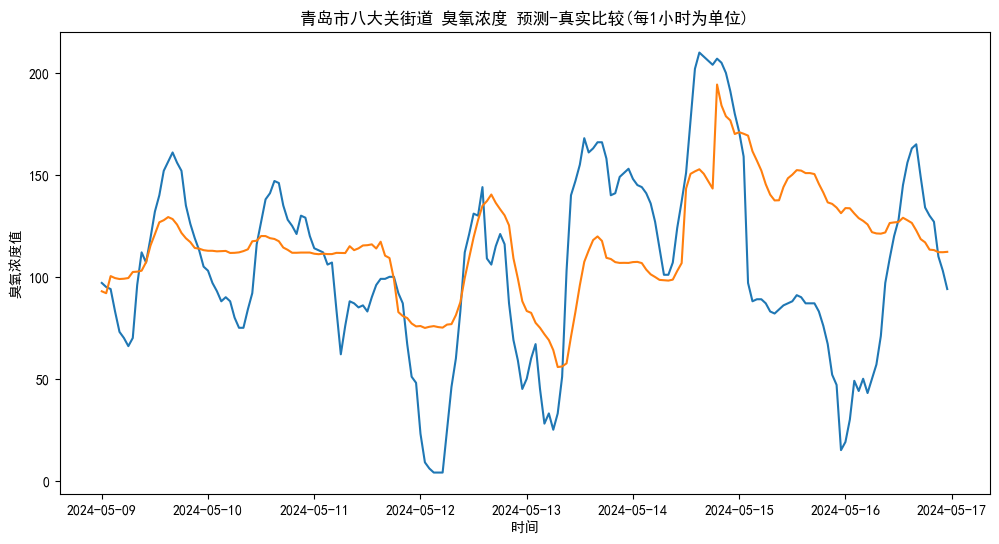

In [17]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
for i in range(len(df_list)):
# 绘制真实值和预测值的曲线
    plt.figure(figsize=(12, 6))
    plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")
    plt.plot(df_list[i]['日期'],y_list[i].values , label='True')
    plt.plot(df_list[i]['日期'],y_pred_list[i] , label='Predictions')
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

# 显示每个具体的数值
    for j in range(0, len(df_list[i]), 10):
        plt.text(df_list[i].loc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
        plt.text(df_list[i].loc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')
    plt.legend()
    plt.show()
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
    print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math


for i in range(len(df_list)):
    # 将每小时的数据转换为最大滑动八小时的数据
    max_rolling_8h = y_list[i].rolling(window=8, min_periods=1).max().dropna()

    # 获取对应的时间戳
    rolling_8h_timestamps = df_list[i]['日期'].iloc[7::8]

    # 确保预测值列表的长度能够被8整除
    remainder = len(y_pred_list[i]) % 8
    if remainder != 0:
        # 如果不整除，去除多余的预测值
        y_pred_list[i] = y_pred_list[i][:-remainder]

    # 对预测值也做类似的处理
    max_rolling_8h_pred = [np.max(y_pred_list[i][j:j+8]) for j in range(0, len(y_pred_list[i]), 8)]
    
    # 确保预测值列表与真实值列表长度相同
    if len(max_rolling_8h) != len(max_rolling_8h_pred):
        # 如果长度不一致，则截断最后一个周期的预测值
        max_rolling_8h_pred = max_rolling_8h_pred[:-1]
    
    # 确保长度一致
    assert len(max_rolling_8h) == len(max_rolling_8h_pred), "Length of max_rolling_8h and max_rolling_8h_pred must be the same"

    plt.figure(figsize=(12, 6))
    plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(最大滑动八小时为单位)")
    
    # 使用每八小时的最大值绘制真实值曲线
    plt.plot(rolling_8h_timestamps, max_rolling_8h.values, label='True Max Rolling 8H')
    
    # 绘制预测值曲线
    plt.plot(rolling_8h_timestamps, max_rolling_8h_pred, label='Predicted Max Rolling 8H')
    
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

    # 显示每个具体的数值
    for j in range(len(max_rolling_8h)):
        plt.text(rolling_8h_timestamps.iloc[j], max_rolling_8h.values[j], f'{max_rolling_8h.values[j]:.2f}', color='blue', fontsize=8, ha='right')
        plt.text(rolling_8h_timestamps.iloc[j], max_rolling_8h_pred[j], f'{max_rolling_8h_pred[j]:.2f}', color='orange', fontsize=8, ha='left')

    plt.legend()
    plt.show()

    # 计算评估指标
    rmse = math.sqrt(mean_squared_error(max_rolling_8h.values, max_rolling_8h_pred))
    r2 = r2_score(max_rolling_8h.values, max_rolling_8h_pred)

    print("rmse:", rmse)
    print("r2 score:", r2)

AssertionError: Length of max_rolling_8h and max_rolling_8h_pred must be the same

In [ ]:
# from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
# import matplotlib.dates as mdates
# from datetime import datetime, timedelta
# date_range_list = []

# start_date = datetime(2024, 5, 9, 0, 0, 0) 
# end_date = datetime(2024, 5, 12, 23, 0, 0)
# while start_date <= datetime(2024, 7, 1, 0, 0, 0):
#     date_range = pd.date_range(start=start_date, end=end_date, freq='H')
#     date_range_list.append(date_range)
#     end_date += timedelta(hours=1)
#     start_date = end_date
#     end_date += timedelta(days=4)
#     end_date -= timedelta(hours=1)
    
# for date_ranges in date_range_list:
#     for i in range(len(df_list)):
#         for index, row in df_list[i].iterrows():
#             if row['日期'] in date_ranges:
#                 plt.figure(figsize=(12, 6))
#                 plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")
#                 plt.plot(row['日期'],y_list[i].values[int(index/5)], label='True')
#                 plt.plot(row['日期'],y_pred_list[i][int(index/5)], label='Predictions')
#                 plt.xlabel('时间')
#                 plt.ylabel('臭氧浓度值')
                


#     # 显示每个具体的数值
#         # for j in range(0, len(df_list[i]), 10):
#         #     plt.text(df_list[i].loc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
#         #     plt.text(df_list[i].loc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')

#         print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
#         print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))
#         # sum += 1
#         # if sum >= 1:
#         #     plt.show()
#         #     sum = 0
#         #     plt.figure(figsize=(12, 6))
#         #     plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")

#     plt.show()








